# Toy Notebook: 1D-Model with adaptation

## Import necessary packages & functions

In [2]:
import numpy as np
import pandas as pd

import matplotlib.ticker as ticker
from matplotlib import cm

import matplotlib.pyplot as plt
import seaborn as sns

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#get the paths to be able to import functions and csv files
%cd /Users/ronja/Documents/GitHub/neural-fields

import sys
sys.path.append('/Users/ronja/Documents/GitHub/neural-fields/py')
csv_path = '/Users/ronja/Documents/GitHub/neural-fields/csv'
sys.path.append(csv_path)

/Users/ronja/Documents/GitHub/neural-fields


In [5]:
#Import necesarry functions from python-scripts of py-folder

#basic package to run simulation
import continuum1d as continuum1d

#package to individually set parameters
from params import setParams

#function to compute fixed points of new system & check their stability of w(x)=dirac measure
#these functions are not necessary anymore if you use py.funcs.run_fixedpoints and run_violation
from analysis import computeFPs, checkFixPtsStability 

#function that combines the test for static, dynamic & double type of instability
from turings import checkStability

#functions that make up the 3d polynomial
from turings import c0, c1, c2

#functions that help visualisations of analyses (nullclines, transfer functions, determinant, trace)
from analysis import activity_ui, activity_ue, F_a

# #  - - functions for the exploration of the adaptation and its' parameters - - # #
# # - - used for the average rate and the phase latency - - # #

#in py.funcs are two functions that average over finite differences
#py.funcs.rateBatches1d and py.funcs.rateBatchesNd 
#We only need to call the latter, it uses the first
from funcs import rateBatchesNd
#to be able to compute H[ue], we need ue.
#we summarised the simulation as well as the identification of fps & their stability in the following
from runFuncs import run_activity, run_fixedpoints, run_violation
from runFuncs import run_latencies_for_activity
#compute the hilbert trafo and the instantaneous phase
from funcs import hilbert_trafo_nd, inst_phase
#to identify, how many timesteps the imag(H[ue]) crosses the zero
from funcs import getSwitchIndex
#to count the amount of nodes necessary until one cycle of oscillation is finished
from funcs import count_nodes_for_descent,  rotation_in_latency




#import plotting-template - this is NOT necesssary, in this exmple, it's to simplify visualisations
#decomment this line, if you do not have the template available
path = '/Users/ronja/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/'
plt.style.use(path + 'template.mplstyle')

# Run simulations - random initialisation
activity-based, integration via fourier-transform, with adaptation

In [6]:
#init class to run simulation all at once
#not necessary anymore
#c1d = continuum1d.continuum1d()

In [7]:
ee = 0.54
ii = 0.0
params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 8*1000}

In [8]:
ue, ui = run_activity(params)

# Run simulation - initialisation around fixed point¶
fixed point of uncoupled system is used for initialisation.

In [9]:
#compute fp-values of uncoupled system.
fps, stab = run_fixedpoints(params)
vio = run_violation(params, fps[0])

print('for the fixed points %s, we have the corresponding stability %s (1=stable, 0=unstable)' %(str(fps), str(stab)))
print('the down-fp %s undergoes the violations %s (static, dynamic, TakensBogdanov)' %(str(fps[0]), str(vio)))
print('For further information, how the violation-test works, see below.')

for the fixed points [[0.14422465 0.51525738]
 [0.81192434 0.99986327]
 [0.98554937 0.9999922 ]], we have the corresponding stability [1, 0, 1] (1=stable, 0=unstable)
the down-fp [0.14422465 0.51525738] undergoes the violations (1, 1, 0) (static, dynamic, TakensBogdanov)
For further information, how the violation-test works, see below.


In [10]:
#choose the fixed point for initialisation
fp = fps[0]

In [11]:
#run simulation init. around fp
ue_fp, ui_fp = run_activity(params, fp=fp)#itype='inte_adaptation', fp=fp)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3188619967.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time_labels)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3188619967.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_labels)


Text(0, 0.5, 'space')

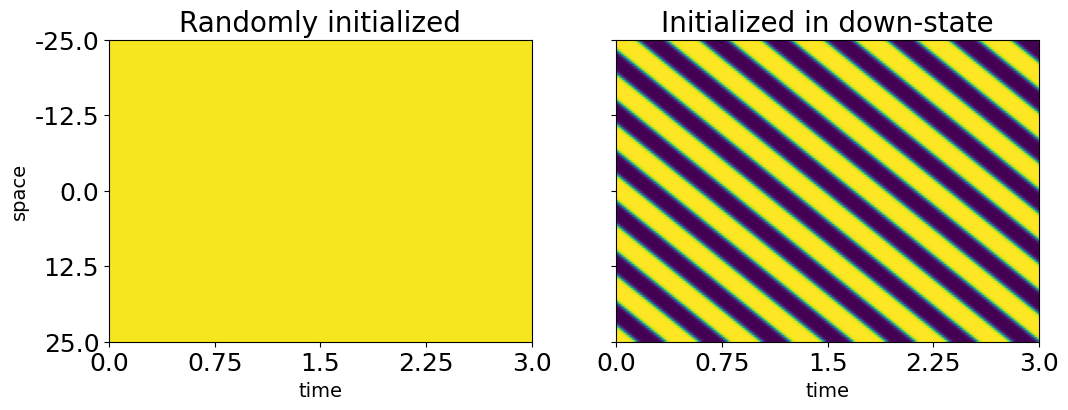

In [12]:
#get all parameters into the params-dict 
#to be able to call also the paramameters we didn't specifically define
params = setParams(params)

#visualize randomly initialized next to init in fp
fix, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4), sharey='all')

duration = 3

#plot the corresponding activites
time_labels = np.linspace(0,duration*1000*0.001,5)
space_labels = np.linspace(-params.length/2, params.length/2, 5)

titles = ['Randomly initialized', 'Initialized in down-state']

ax0.imshow(ue.T[:,-int(duration*1000*(1/params.dt)):], vmin=0, vmax=1, aspect='auto')
ax1.imshow(ue_fp.T[:,-int(duration*1000*(1/params.dt)):], vmin=0, vmax=1, aspect='auto')

for idx, ax in enumerate([ax0, ax1]):
    ax.set_title(titles[idx])
    ax.set_xlabel('time', fontsize=14)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=time_labels)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=space_labels)
    
ax0.set_ylabel('space', fontsize=14)

# Evolution of activity around fixed point

In [13]:
#random nodes
indeces = [24,38,89,110]

#choose which duration of the simulated activity you want to show
#I want to include how it evolves from the init. Therefore, starting point=timestep 0.
duration = [0, 10000] 

## Randomly initialized

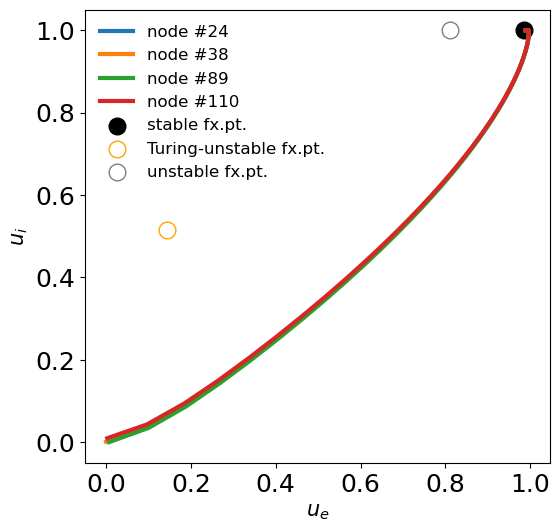

In [14]:
plt.figure(figsize=(6,6))

#cut activity of ue into duration-time
ue_plot = ue.T[:,int(duration[0]):int(duration[1])]
ui_plot = ui.T[:,int(duration[0]):int(duration[1])]

for idx in indeces:
    plt.plot(ue_plot[idx], ui_plot[idx], label='node #%i' %idx)
    
plt.scatter(fps[-1][0], fps[-1][1], label='stable fx.pt.', c='black')
plt.scatter(fps[0][0], fps[0][1], label='Turing-unstable fx.pt.', 
            facecolor='white', edgecolor='orange')
plt.scatter(fps[1][0], fps[1][1], label='unstable fx.pt.', 
            facecolor='white', edgecolor='grey')
plt.xlabel(r'$u_e$', fontsize=15)
plt.ylabel(r'$u_i$', fontsize=15)
plt.legend(fontsize=12)

## Initialized in Fixed Point

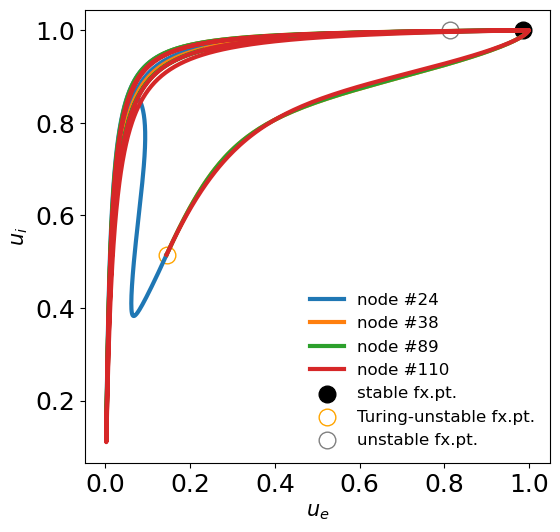

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

#cut activity of ue into duration-time
ue_plot_fp = ue_fp.T[:,int(duration[0]):int(duration[1])]
ui_plot_fp = ui_fp.T[:,int(duration[0]):int(duration[1])]

for idx in indeces:
    ax.plot(ue_plot_fp[idx], ui_plot_fp[idx], label='node #%i' %idx)
    
plt.scatter(fps[-1][0], fps[-1][1], label='stable fx.pt.', c='black')
plt.scatter(fps[0][0], fps[0][1], label='Turing-unstable fx.pt.', 
            facecolor='white', edgecolor='orange')
plt.scatter(fps[1][0], fps[1][1], label='unstable fx.pt.', 
            facecolor='white', edgecolor='grey')
plt.xlabel(r'$u_e$', fontsize=15)
plt.ylabel(r'$u_i$', fontsize=15)
plt.legend(fontsize=12)

# Nullclines
In the following, we visualise the nullclines & how the activity of  $u_e$ &  $u_i$ evolve around it. To do so, we use the fixed points & nullclines of the uncoupled system while we simulate activity in the coupled system. Since we use the fixed point values of the uncoupled system, the visualisation of the nullclines for this system is done.

Note: The change from the model without adaptation to the model with adaptation has to be considered in the determination of the fixed points. We can make use of the nullclines being defined by the differential equations simulatneously being zero such that from $0=-a+F_a(u_e) \Leftrightarrow a=F_a(u_e)$ the following follows $0=-u_e+F_e(w_{ee}u_e-w_{ei}u_i-ba+I_e) \Leftrightarrow 0=-u_e+F_e(w_{ee}u_e-w_{ei}u_i-bF_a(u_e)+I_e)$. Therefore, we can identify the fixed points $(\bar{u}_e,\bar{u}_i)$ by the two-dimensional system, inserting $a=F_a(u_e)$. The fixed point for the 3-dimensional system is then given by $(\bar{u}_e,\bar{u}_i, F_a(\bar{u}_e))$.

Make no mistake, the stability of $(\bar{u}_e,\bar{u}_i, F_a(\bar{u}_e))$ has to be determined by the (Jacobian of the) 3d-system though!

fp=[0.1543635  0.50552903] has instability static=1, dynamic=1, double=0
fp=[0.83429975 0.99987862] has instability static=1, dynamic=1, double=0
fp=[0.98115151 0.99998923] has instability static=0, dynamic=0, double=0
fp=[0.16024848 0.51694987] has instability static=1, dynamic=1, double=0
fp=[0.83614149 0.99988225] has instability static=1, dynamic=1, double=0
fp=[0.98105319 0.99998922] has instability static=0, dynamic=0, double=0


/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return params.mu_e - (1/params.beta_e) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:53: RuntimeWarning: divide by zero encountered in log
  return params.mu_e - (1/params.beta_e) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:56: RuntimeWarning: divide by zero encountered in true_divide
  return params.mu_i - (1/params.beta_i) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:56: RuntimeWarning: divide by zero encountered in log
  return params.mu_i - (1/params.beta_i) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return params.mu_e - (1/params.beta_e) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:53: RuntimeWarning: divide by zero encountered in log
  r

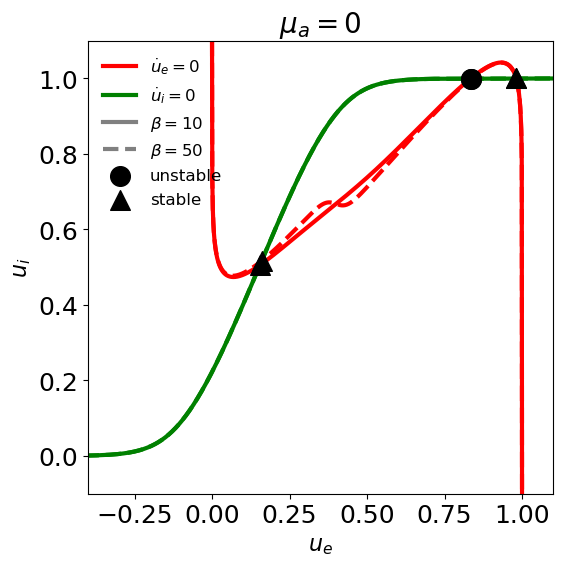

In [16]:
betas = [10, 50]
plt.figure(figsize=(6,6))

for l, beta in enumerate(betas):
    ee = 0.5
    ii = -0.05

    params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 8*1000, 'tau_a': 600, 'mu_a': 0.4, 'beta_a': beta}

    params = setParams(params)
    fps = computeFPs(params)
    stab = checkFixPtsStability(fps, params)
    
    u = np.linspace(0,1,1201)
    zero_line = np.linspace(0,0,len(u))

    #use property c0=0 ('has zero-eigenvalue' - Curtu & Ermentrout 2004)
    k=np.linspace(0,2,501)

    for fp in fps:
        static, dynamic, double = checkStability(k, fp, params)
        print('fp=%s has instability static=%i, dynamic=%i, double=%i' %(str(fp), static, dynamic, double))
    
    markers = ['o', '^']
    lines = ['solid', 'dashed', 'dotted']
    labels=['unstable', 'stable']
    
    nc_ui = activity_ui(u, params)
    nc_ue = activity_ue(u, params)
    
    if nc_ui[1]<1:
        nc_ui[0] = 1.1
    if nc_ui[-2]>0:
        nc_ui[-1] = -0.1
    
    if nc_ue[1]>0:
        nc_ue[0] = -0.1
    if nc_ue[-2]<1:
        nc_ue[-1] = 1.1
        
    
    plt.plot(u,nc_ui, c='red', ls=lines[l], zorder=0)
    plt.plot(nc_ue,u, c='green', ls=lines[l], zorder=0)

    for i, fp in enumerate(fps):
        plt.scatter(fp[0], fp[1], s=200, zorder=2, marker=markers[stab[i]], c='black')

    

    
plt.plot(0,0, c='red', label=r'$\dot{u}_e=0$')
plt.plot(0,0, c='green', label=r'$\dot{u}_i=0$')
plt.plot(0,0, c='gray', ls='solid', label=r'$\beta=%i$' %betas[0])
plt.plot(0,0, c='gray', ls='dashed', label=r'$\beta=%i$'%betas[1])

plt.scatter(-100,-100, s=200, zorder=0, marker=markers[0], c='black', label='unstable')
plt.scatter(-100,-100, s=200, zorder=0, marker=markers[1], c='black', label='stable')

plt.xlabel(r'$u_e$', fontsize=16)
plt.ylabel(r'$u_i$', fontsize=16)
    

plt.legend(loc='upper left', fontsize=12)
plt.title(r'$\mu_a=%i$' %params.mu_a)

plt.xticks()#(fontsize=14)
plt.yticks()#(fontsize=14)

plt.xlim([-0.4, 1.1])
plt.ylim([-0.1, 1.1])
plt.show()

# Investigation of the state space - default setting
Certain aspects of the analysis were already computed for the default setting. Therefore, one can call 'default.csv' to import the pandas-dataframe the contains the information/quantities which were already determined. State space for $(I_e, I_i)\in[0,1]^2$.

In [17]:
path = '/Users/ronja/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/'
plt.style.use(path + 'template.mplstyle')

def setAxes(df, nmb):
    
    # Add minorticks on the colorbar to make it easy to read the
    # values off the colorbar.
    
    nmb_labels = 5
                
    idx_x = np.linspace(0,len(df.columns.values)-1, nmb_labels).astype(int)
    idx_y = np.linspace(0,len(df.index.values)-1, nmb_labels).astype(int)
        
    xliste= np.round(df.columns.values, decimals=2)[idx_x]
    yliste= np.round(df.index.values, decimals=2)[idx_y]
    
    xlabels=list('%.1f'%(e) for e in xliste)
    ylabels=list('%.1f'%(e) for e in yliste)
    
    return xlabels, ylabels

def plotDiscreteMap(df, xaxis='I_e', yaxis='I_i', scatters=False,
                    title='State space with adaptation', colorbar=True):
    
    p_colors = cm.get_cmap('Accent', 4)
    
    stabis = df.pivot_table('stability', columns=xaxis, index=yaxis)
    statics = df.pivot_table('static', columns=xaxis, index=yaxis)
    dynamics = df.pivot_table('dynamic', columns=xaxis, index=yaxis)
    doubles = df.pivot_table('double', columns=xaxis, index=yaxis)
    p_randoms = df.pivot_table('p_random', columns=xaxis, index=yaxis)
    p_downs = df.pivot_table('p_down', columns=xaxis, index=yaxis) #kommentiere diese zeile aus, falls multistabi nicht erhoben wird
    compare = p_randoms.eq(p_downs) #kommentiere diese zeile aus, falls multistabi nicht erhoben wird
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    
    unstable_color = 'white'
    stable_color='black'
    
    nmb_labels = 5
                
    xlabels, ylabels = setAxes(stabis, nmb_labels)
    
    pos = ax.imshow(p_randoms, origin='lower', vmin=1, vmax=4, aspect='auto', cmap=p_colors, alpha=0.7) #
    c1 = ax.contour(stabis, origin='lower', vmin=0, vmax=2, levels=1, 
                    colors=[unstable_color, stable_color, 'green'])
    c2 = ax.contour(statics, origin='lower', vmin=0, vmax=1, levels=0, 
                    colors=[unstable_color], linestyles='dashed')
    c22 = ax.contour(dynamics, origin='lower', vmin=0, vmax=1, levels=0, 
                    colors=['gray'], linestyles='dashed')
    c3 = ax.contour(compare, origin='lower', vmin=0, vmax=1, levels=0, colors=[stable_color], 
               linestyles='dashed') #kommentiere diese zeile aus, falls multistabi nicht erhoben wird
    
   
    h1,l1 = c1.legend_elements()
    h2,l1 = c2.legend_elements()
    h22,l1 = c22.legend_elements()
    h3,l1 = c3.legend_elements()
    plt.legend([h1[0], h1[1], h2[0], h22[0], h3[0]], ['Hopf', 'Bistable', 'Static', 'Dynamic', 'Multi'], 
               loc='upper left')
    ax.set_title(title)
    
    
    markers = ['X', 'D', 's', 'o', 'P', '^']
    count=0
    if not scatters.any()==False:
        for scatter in scatters:
            scatter0 = stabis.columns.values.flat[np.abs(stabis.columns.values - scatter[0]).argmin()]#findNearest(stabis.index.values, scatter[0])
            scatter1 = stabis.index.values.flat[np.abs(stabis.index.values - scatter[1]).argmin()] #findNearest(stabis.index.values, scatter[1])
            xnodes = np.linspace(0, len(stabis.columns.values)-1, len(stabis.columns.values))
            ynodes = np.linspace(0, len(stabis.index.values)-1, len(stabis.index.values))
            ax.scatter(xnodes[list(stabis.columns.values).index(scatter0)], 
                       ynodes[list(stabis.index.values).index(scatter1)], 
                       s=250, c='blue', marker=markers[count], zorder=2) 
            count+=1
        
    # Add minorticks on the colorbar to make it easy to read the
    # values off the colorbar.
    
    ax.xaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_xticklabels(labels=xlabels, fontsize=12)
    ax.yaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_yticklabels(labels=ylabels, fontsize=12)
    
    ax.set_xlabel(r'$%s$' %xaxis)
    ax.set_ylabel(r'$%s$' %yaxis, labelpad=10, rotation=0)
    
    ax.label_outer()
    
    mini = 1
    maxi = 4
    cbar_ticks=np.linspace(mini,maxi,4)
    cbar_ticks=np.around(cbar_ticks, decimals=0)
    cbar_labels=['stat', 'temp', 'spat', 'spatiotemp']
    
    if colorbar:
        # Create colorbar
        cb_ax = fig.add_axes([.93,.126,.04,.754])
        cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
        cbar.ax.set_ylabel('pattern-type', rotation=-90, va="bottom")
        cbar.ax.set_yticklabels(cbar_labels, rotation=-90)
        cbar.minorticks_off()
    
    
    plt.show()

In [18]:
df = pd.read_csv('csv/adaps-explo/high-adaps.csv')

Set $\texttt{scatter=[[I_e, I_i], [...]]}$ to position markers at the positions you're interested in, e.g. if you want to take look at a certain parametrization for which you have both bistability in the uncoupled system, but Turing instability in the down-state (as below)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3874459381.py:47: UserWarning: No contour levels were found within the data range.
  c2 = ax.contour(statics, origin='lower', vmin=0, vmax=1, levels=0,
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3874459381.py:49: UserWarning: No contour levels were found within the data range.
  c22 = ax.contour(dynamics, origin='lower', vmin=0, vmax=1, levels=0,
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3874459381.py:51: UserWarning: No contour levels were found within the data range.
  c3 = ax.contour(compare, origin='lower', vmin=0, vmax=1, levels=0, colors=[stable_color],
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3874459381.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xlabels, fontsize=12)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3874459381.py:83: UserWarning: FixedFormatter should onl

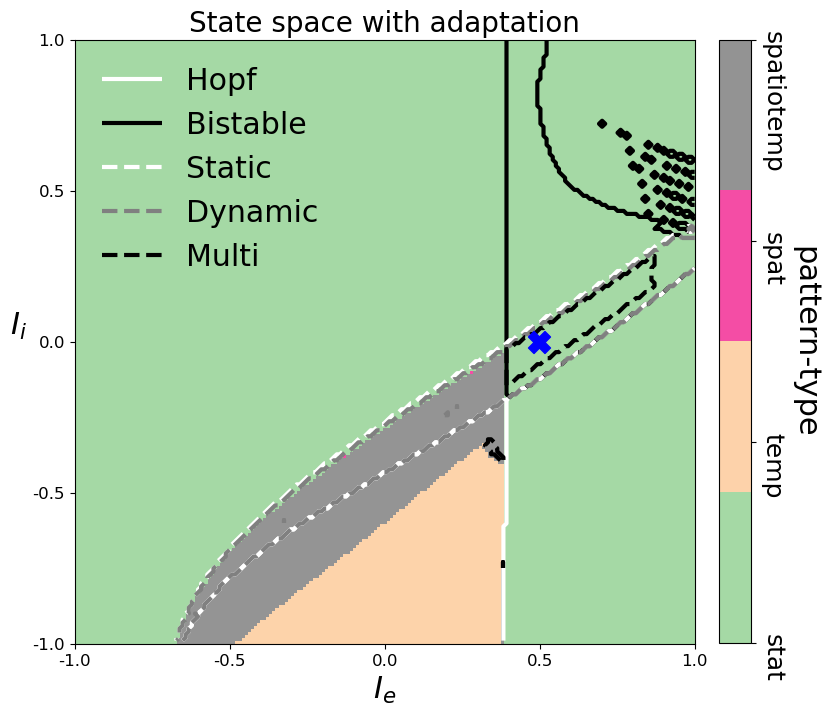

In [19]:
ee= 0.5
ii= 0.0

plotDiscreteMap(df, scatters=np.array([[ee, ii]]))

# Visualise violation type

A stable fixed point of the uncoupled system can undergo "different types of bifurcations" ("lose stability"), which is detectable by an extended analysis (i.e. pattern formation in the coupled system by identification of Turing-/Turing-Hopf instability). 

For approaches, see either Harris & Ermentrout 'Traveling waves in a spatially-distributed Wilson–Cowan model of cortex: From fronts to pulses' (2018), or Wyller et al 'Turing instability and pattern formation in a two-population neuronal network model' (2007).

We did have to adjust the stability analysis to the 3-dimensional system with adaptation though. For that we used the help of Curtu & Ermentrout (2004) 'Pattern Formation in a Network of Excitatory and Inhibitory Cells with Adaptation'. They make use of the fact, that the Eigenvalues of a 3-dimensional Jacobian matrix are determined by a 3-dimensional Polynomial, i.e. a cubic polynomial. Therefore, we can 'check' certain conditions to determine the type of occuring instability.

We will use the above chosen setting (blue $\textbf{X}$ in state space).

Note: We have to determine the violation type for each fixed point. For the chosen setting, we have 3 fixed points  $\to$ do the same 3 times.

In [20]:
params = {'I_e': ee, 'I_i': ii, 'b': 0.25, 'mu_a': 0.4, 'beta_a': 10, 'end_t': 5*1000}

#compute fp-values of uncoupled system and their corresponding stability.
fps, stab = run_fixedpoints(params)

print('for the fixed points %s, we have the corresponding stability %s (1=stable, 0=unstable)' %(str(fps), str(stab)))

for the fixed points [[0.13335441 0.49415868]
 [0.83434037 0.99990552]
 [0.9811507  0.99999161]], we have the corresponding stability [1, 0, 1] (1=stable, 0=unstable)


## Types of instability
The characteristic polynomial of the Jacobian matrix $A_3(k)|_{(\bar{u}_e,\bar{u}_i,F_a(\bar{u}_e))}$ has the form

$P(\lambda) = \lambda^3+c_2(k)\lambda^2+c_1(k)\lambda+c_0(k)$.

The fixed point $(\bar{u}_e,\bar{u}_i,F_a(\bar{u}_e)$ remains stable, if the real part of all Eigenvalues $\lambda_0,\ \lambda_1,\ \lambda_2$ remains really negative. This is not the case if one of the following happens:

There is a $k_0>0$ such that
1. $c_0(k_0)=0\ \Rightarrow\ P(\lambda)$ has a zero-Eigenvalue. We call this Turing instability $\textit{static}$. 
2. $c_2(k_0)c_1(k_0)-c_0(k_0)=0\ \Rightarrow\ P(\lambda)$ has an imaginary-Eigenvalue. We call this Turing instability $\textit{dynamic}$. 
3. $c_1(k_0)=0=c_0(k_0)\ \Rightarrow\ P(\lambda)$ has a double-zero-Eigenvalue. This type of instability is a Takens-Bogdanov instability. (We call it short-hand $\textit{double}$.) 

In [21]:
#set the range for increasing wavenumber k
k = np.linspace(-3,3,801)
zero_line = np.linspace(0, 0, len(k))
params = setParams(params)

In [22]:
#check stability for donw-state
fp= fps[0]

c_20 = c2(k, fp, params)
c_10 = c1(k, fp, params)
c_00 = c0(k, fp, params)

cs0 = [c_00, c_10, c_20]

vio = run_violation(params, fp)
static0, dynamic0, double0 = vio[0], vio[1], vio[2]

print('For fixed point %s, we have the (in-)stability' %str(fp))
print('1. static: %i (0=no, 1=yes)' %static0)
print('2. dynamic: %i (0=no, 1=yes)' %dynamic0)
print('3. double: %i (0=no, 1=yes)' %double0)


#again for visualisation reasons: let the simulation run, init. around fp:
ue0, ui0 = run_activity(params, fp=fp)

For fixed point [0.13335441 0.49415868], we have the (in-)stability
1. static: 1 (0=no, 1=yes)
2. dynamic: 1 (0=no, 1=yes)
3. double: 0 (0=no, 1=yes)


In [27]:
#check stability for saddle node
fp= fps[1]

c_21 = c2(k, fp, params)
c_11 = c1(k, fp, params)
c_01 = c0(k, fp, params)

cs1= [c_01, c_11, c_21]


print('For fixed point %s, we have instability' %str(fp))
print('Therefore, we don\'t check, if it loses stability under consideration of a spatial perturbation...')
print('It already is unstable :D')


#again for visualisation reasons: let the simulation run, init. around fp:
ue1, ui1 = run_activity(params, fp=fp)

For fixed point [0.83434037 0.99990552], we have instability
Therefore, we don't check, if it loses stability under consideration of a spatial perturbation...
It already is unstable :D


In [24]:
#check stability for up-state
fp= fps[-1]

c_22 = c2(k, fp, params)
c_12 = c1(k, fp, params)
c_02 = c0(k, fp, params)

cs2 = [c_02, c_12, c_22]

vio = run_violation(params, fp)
static2, dynamic2, double2 = vio[0], vio[1], vio[2]

print('For fixed point %s, we have the (in-)stability' %str(fp))
print('1. static: %i (0=no, 1=yes)' %static2)
print('2. dynamic: %i (0=no, 1=yes)' %dynamic2)
print('3. double: %i (0=no, 1=yes)' %double2)

#again for visualisation reasons: let the simulation run, init. around fp:
ue2, ui2 = run_activity(params, fp=fp)

For fixed point [0.9811507  0.99999161], we have the (in-)stability
1. static: 0 (0=no, 1=yes)
2. dynamic: 0 (0=no, 1=yes)
3. double: 0 (0=no, 1=yes)


/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/4274112987.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time_labels)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/4274112987.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_labels)


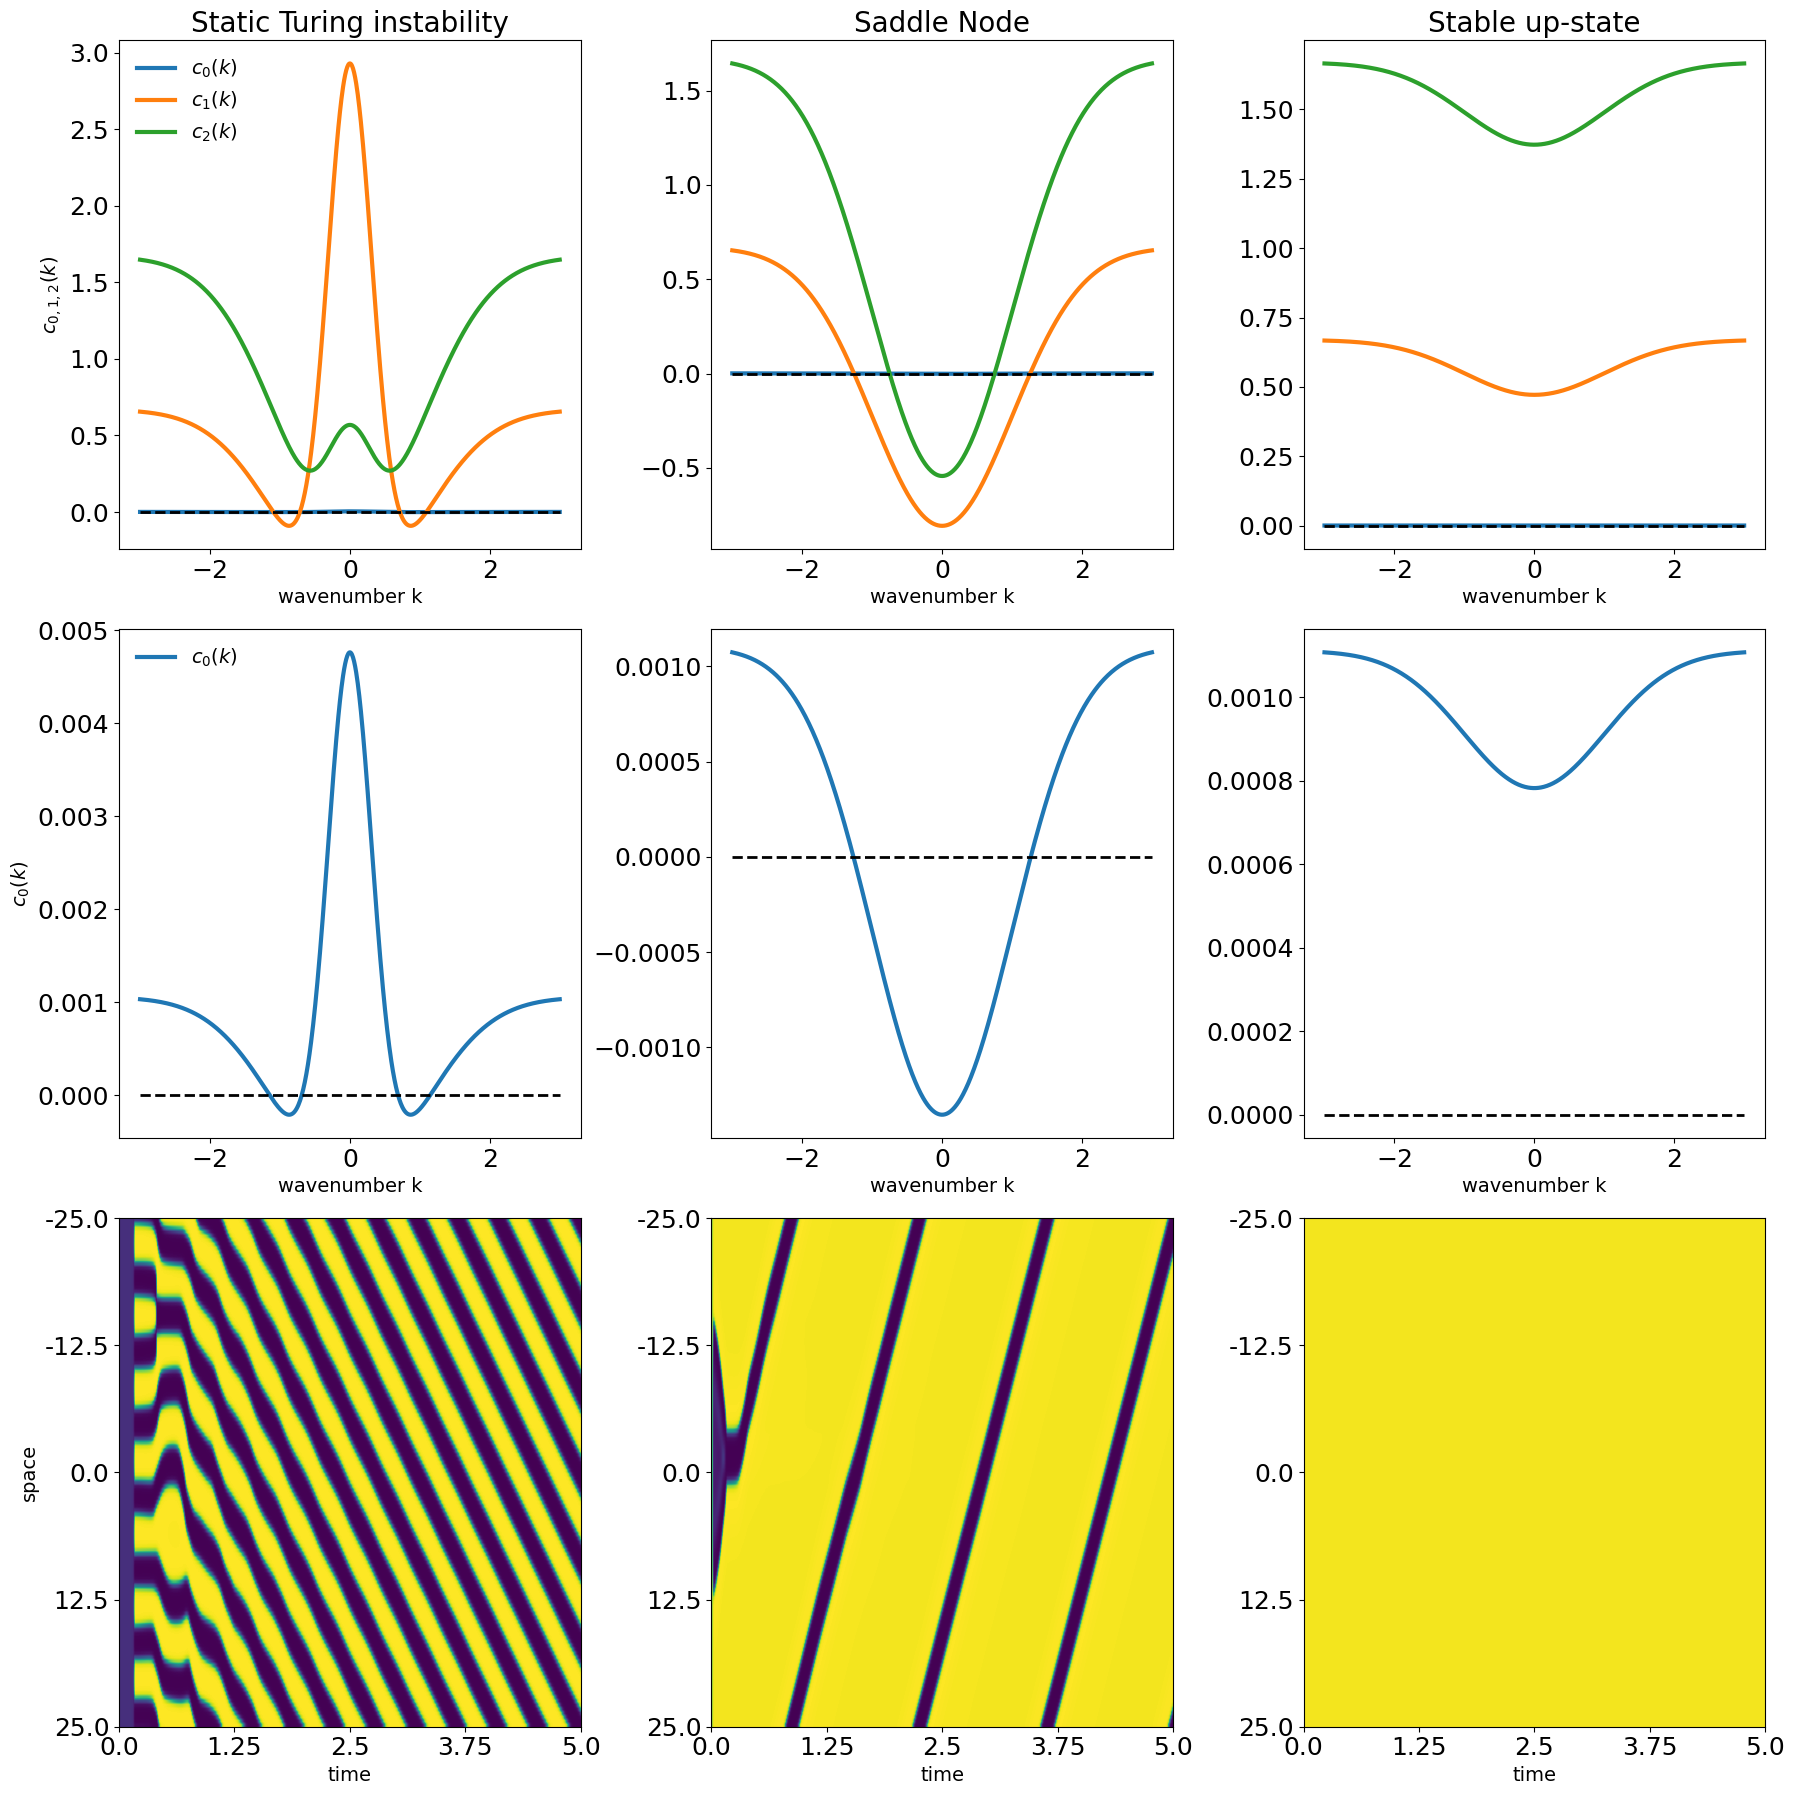

In [28]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(3, 3, figsize=(18,18))

zero_line = np.linspace(0,0, len(k))

row1 = [ax0, ax1, ax2]
row2 = [ax3, ax4, ax5]
row3 = [ax6, ax7, ax8]
all_cs = [cs0, cs1, cs2]
all_c0s = [c_00, c_01, c_02]
all_ues = [ue0, ue1, ue2]

titles = ['Static Turing instability', 'Saddle Node', 'Stable up-state']

#plot the c-functions per state over k
for idx, ax in enumerate(row1):
    for i, c in enumerate(all_cs[idx]):
        ax.plot(k, c, label=r'$c_%i(k)$' %i)
        
    ax.plot(k, zero_line, ls='dashed', c='black', lw=2)
    ax.set_title(titles[idx])
    ax.set_xlabel('wavenumber k', fontsize=14)
    
ax0.legend(loc='upper left', fontsize=14)
ax0.set_ylabel(r'$c_{0,1,2}(k)$', fontsize=14)

#plot a close-up of c_0 per state
for idx, ax in enumerate(row2):
    ax.plot(k, all_c0s[idx], label=r'$c_0(k)$')
    ax.plot(k, zero_line, ls='dashed', c='black', lw=2)
    #ax.set_title(titles[idx])
    ax.set_xlabel('wavenumber k', fontsize=14)
    

ax3.legend(loc='upper left', fontsize=14)
ax3.set_ylabel(r'$c_0(k)$', fontsize=14)
    
#plot the corresponding activites
time_labels = np.linspace(0,params.end_t*0.001,5)
space_labels = np.linspace(-params.length/2, params.length/2, 5)

for idx, ax in enumerate(row3):
    ax.imshow(all_ues[idx].T, vmin=0, vmax=1, aspect='auto')
    ax.set_xlabel('time', fontsize=14)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=time_labels)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=space_labels)
    
ax6.set_ylabel('space', fontsize=14)
    
fig.tight_layout(pad=0.5)

# Exploration of the adaptation state space and its' parameters
## Temporal frequencies in the state space

In the following we plot the dominant temporal frequency per external input values $(I_e, I_i)\in[-1,1]^2$ for which we have spatiotemporal patterns (i.e. traveling waves) if the system was initialised in the down-state.

In [29]:
time_frequs = pd.read_csv('csv/adaps-explo/high-adaps_temp_frequs.csv')

In [30]:
def plotMap(df, xaxis='I_e', yaxis='I_i', scatter=False,
                    title='Dominant frequencies', colorbar=True,
                   plotty = 'dom_frequ', colorbar_title = 'dominant frequ.'):
    
    p_colors = cm.get_cmap('Accent', 4)
    
    plots = df.pivot_table(plotty, columns=xaxis, index=yaxis)
    
    fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=160)

    nmb_labels = 5
                
    xlabels, ylabels = setAxes(plots, nmb_labels)
    
    vals=df[plotty].to_numpy()
    mini = min(vals)
    if any(np.isinf(vals)):
        maxi=7
    else:
        maxi = 6#max(vals)
    
    pos = ax.imshow(plots, origin='lower', vmin=mini, vmax=maxi, aspect='auto', cmap='viridis')
    
    ax.set(title=title)
     
    # Add minorticks on the colorbar to make it easy to read the
    # values off the colorbar.
    
    ax.xaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_xticklabels(labels=xlabels, fontsize=25)
    ax.yaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_yticklabels(labels=ylabels, fontsize=25)
    
    ax.set_xlabel(r'$%s$' %xaxis, fontsize=25)
    ax.set_ylabel(r'$%s$' %yaxis, labelpad=10, rotation=0, fontsize=25)
    
    ax.label_outer()
    
    cbar_ticks=np.linspace(mini,maxi,4)
    cbar_ticks=np.around(cbar_ticks, decimals=0)
    cbar_labels=['stat', 'temp', 'spat', 'spatiotemp']
    
    if colorbar:
        # Create colorbar
        cb_ax = fig.add_axes([.93,.126,.04,.754])
        cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
        cbar.ax.set_ylabel(colorbar_title, rotation=-90, va="bottom", fontsize=25)
   #     cbar.ax.set_yticklabels(cbar_labels, rotation=-90)
        
        
        cbar.minorticks_on()
        
    
        
#    plt.legend(loc='lower right')
    
    
    
    plt.show()

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/2087490988.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xlabels, fontsize=25)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/2087490988.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabels, fontsize=25)


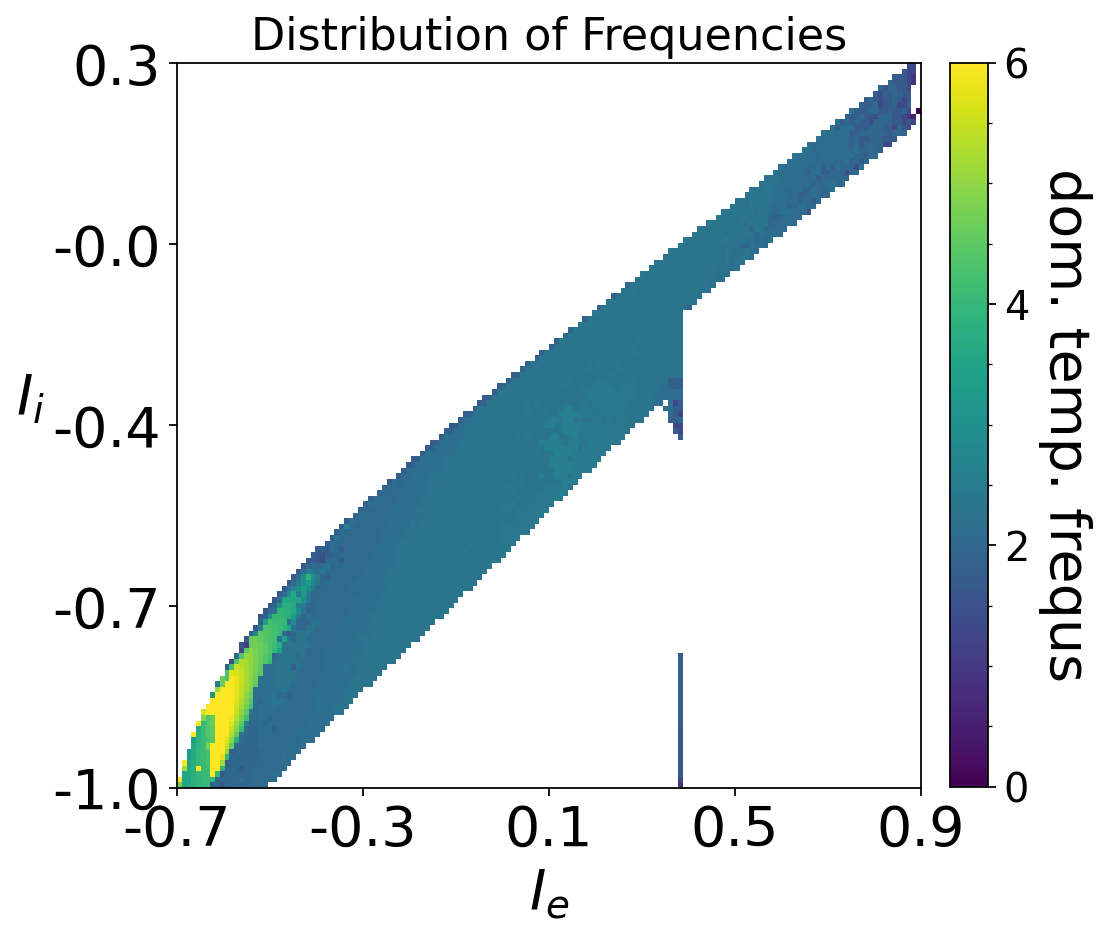

In [31]:
plotMap(time_frequs, title='Distribution of Frequencies', 
                plotty='dom_frequ', colorbar = True, colorbar_title='dom. temp. frequs')

We want to explore how $b$ and $\tau_a$ change the traveling waves. This helps us to identify, which ranges make the most sense. I do this for two different adaptation-dataframes: Once with $\mu_a=0=\mu_{e,i},\ \beta_a=5=\beta_{e,i}$. The other one if for the same setting as the state space shown above, with $\mu_a=0.4,\ \beta_a=10$. I start with $b=0.25,\ \tau_a=600$. For these, I identify parameterizations for which we have bistability without adaptation and 

(i) Bistability with adaptation, static Turing-instability in down with p_random=1, p_down=4 $\\ $
(ii) Bistability with adaptation, no Turing-instability with p_random=1, p_down=4 $\to$ "boundary effect"? $\\ $
(iii) Monostability with adaptation, p_random=p_down=4 $\\ $
(iv) Multistability with adaptation, p_random=1, p_down=4 $\\ $

In [32]:
#these settings are for resolution: 101x101; csv: high_default, adaps_101x101; \mu_a=0, \beta_a=5.
dic = {'(i)': [[0.42, -0.1]],
       '(ii)': [[0.4, -0.08]],
       '(iii)': [[0.24, -0.22]],
       '(iv)': [[0.26, -0.2]]}
cases = pd.DataFrame(data=dic)
cases

,(i),(ii),(iii),(iv)
0,"[0.42, -0.1]","[0.4, -0.08]","[0.24, -0.22]","[0.26, -0.2]"


In [33]:
bi = pd.read_csv('csv/b_a_df_trial.csv')
bii = pd.read_csv('csv/ii_b_a_df_trial.csv')
biii = pd.read_csv('csv/iii_b_a_df_trial.csv')
biv = pd.read_csv('csv/iv_b_a_df_trial.csv')

taui = pd.read_csv('csv/tau_a_df_trial.csv')
tauii = pd.read_csv('csv/ii_tau_a_df_trial.csv')
tauiii = pd.read_csv('csv/iii_tau_a_df_trial.csv')
tauiv = pd.read_csv('csv/iv_tau_a_df_trial.csv')

In [34]:
def plotDataFrames(dfList1, dfList2, 
                   pams=['b', 'tau_a'], features=['dom_frequ', 'down_duration_ratio', 'up_duration_ratio'],
                   labels=['(i)', '(ii)', '(iii)', '(iv)'], 
                   colors=['navy', 'mediumblue', 'dodgerblue', 'skyblue'], 
                   titles=['dom. temp. frequ. [Hz]', 
                           'down duration ' + r'$[\frac{ratio}{oscillation}]$', 
                           'up duration ' + r'$[\frac{ratio}{oscillation}]$']):
  
    
    nmb_cols = len(titles)
    fig, axes = plt.subplots(2, nmb_cols, figsize=(18,6))
    
    for indexis, ax in enumerate(axes[0]):
        ax.set_title(titles[indexis])
        for idx, df in enumerate(dfList1):
          df.plot(ax=ax, x=pams[0],  y=features[indexis], c=colors[idx],
                  label=labels[idx])
        
    for indexis, ax in enumerate(axes[1]):
        for idx, df in enumerate(dfList2):
          df.plot(ax=ax, x=pams[1],  y=features[indexis], c=colors[idx],
                                label=labels[idx])
    
    
  #  ax1.set_ylim([-0.1,3])
  #  ax2.set_ylim([-0.1,3])
    
    for ax in axes[0]:
        ax.set_xlabel(r'$b$')
    
  #  ax1.set_ylim([-0.1,1.1])
  #  ax2.set_ylim([-0.1,1.1])
    
    for ax in axes[1]:
        ax.set_xlabel(r'$\tau_a$')
    
    for ax in axes[0]:
       ax.legend().remove()

    for ax in axes[1,:-1]:
       ax.legend().remove()
       
    axes[-1][-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    plt.show()

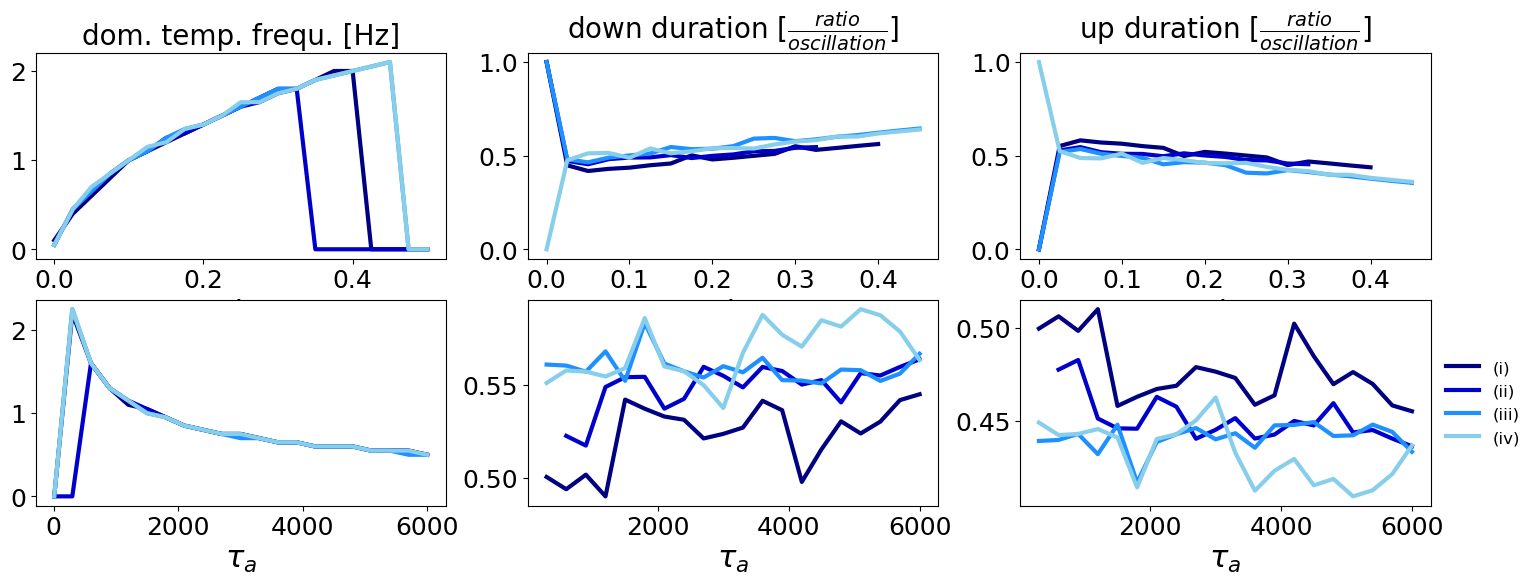

In [35]:
plotDataFrames([bi, bii, biii, biv], [taui, tauii, tauiii, tauiv])

Note: Case (ii) different: Bistable without & with adaptation, static and dynamic Turing instability.

In [36]:
#these settings are for resolution: 201x201; csv: high_default, high-adaps; \mu_a=0.4, \beta_a=10.
dic = {'(i)': [[0.47, 0.01]],# [0.72, 0.16]], 
       '(ii)': [[0.4, -0.14]], #[0.86, 0.27]], 
       '(iii)': [[0.2, -0.25]], #[0.38, -0.04]], 
       '(iv)': [[0.39, -0.04]]}, #[None, None]]}
cases = pd.DataFrame(data=dic)
cases

,(i),(ii),(iii),(iv)
0,"[[0.47, 0.01]]","[[0.4, -0.14]]","[[0.2, -0.25]]","[[0.39, -0.04]]"


In [37]:
bi2 = pd.read_csv('csv/i_b_df.csv')
bii2 = pd.read_csv('csv/ii_b_df.csv')
biii2 = pd.read_csv('csv/iii_b_df.csv')
biv2 = pd.read_csv('phase_lats/case_iv_b.csv')

taui2 = pd.read_csv('csv/i_tau_a_df.csv')
tauii2 = pd.read_csv('csv/ii_tau_a_df.csv')
tauiii2 = pd.read_csv('csv/iii_tau_a_df.csv')
tauiv2 = pd.read_csv('phase_lats/case_iv_tau.csv')

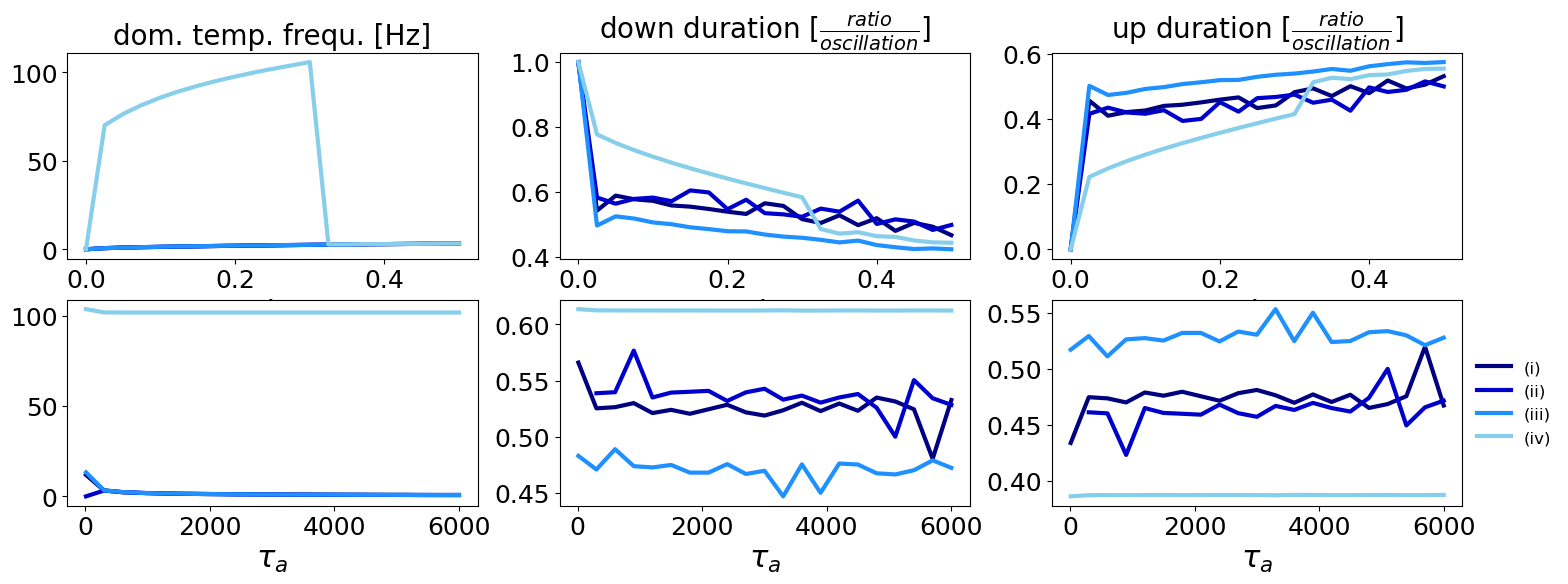

In [38]:
plotDataFrames([bi2, bii2, biii2, biv2], [taui2, tauii2, tauiii2, tauiv2])

# Average rate of change in acitivity

Below, we computed the average rate of change in activity of periodic traveling waves for the default setting of the model with adaptation. We took the state space from above, identiefied all parameter-settings (i.e. $I_e-I_i$-combinations) that showed traveling waves if initalised in the Turing-unstable down-state and computed the corresponding average rate of change in activity of the excitatory populations over time and space.

Method:

Assume $u_{n,t}$ is the activity of node number $n$ at time step $t$. Compute the finite difference

$ 
    v_{n,t}=\frac{|u_{n,t+1}u_{n,t}|}(\Delta t)
$

for every node $n=1,...,N$ and time step $t=1t_0,...,T$ (whereas $t_0$ is a time step $after$ transient time). Then we firstly took the average over time $avg(n)=\frac{1}{T-t_0}\sum_{t=t_0}^{T}v_{n,t}$ and then over nodes $avg=\frac{1}{N}\sum_{n=1}^Navg(n)$ which is then the average rate of change in activity u.

In [39]:
#to be able to compute the average rate of change, we firstly need ue
from py.runFuncs import run_activity, run_fixedpoints

#choose long runtime for a more accurate average. but batch_size > 1
params={'I_e': 0.6, 'I_i': 0.08, 'end_t': 16*1000, 'b': 0.25,
            'seed': True, 'seed_amp': 0.01}

params = setParams(params)

fps, stab = run_fixedpoints(params)
fp=fps[0]

ue, ui = run_activity(params, fp=fp)

1d Model initialised.


In [40]:
#dumb-straight-forwards-approach: take the last 75% of the runtime 
#independet of how long it ran
duration = int(0.75*(params.end_t*(1/params.dt)))

In [41]:
fs = 20
dpi = 160
time_labels = np.linspace(0,int(duration/10000),9)
space_labels = np.linspace(-int(params.length/2),int(params.length/2),5)
cmap = 'viridis'

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/2878858082.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/2878858082.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_labels, fontsize=fs)


[Text(1, 0.0, '0'),
 Text(1, 0.3333333333333333, '0.33'),
 Text(1, 0.6666666666666666, '0.66'),
 Text(1, 1.0, '1')]

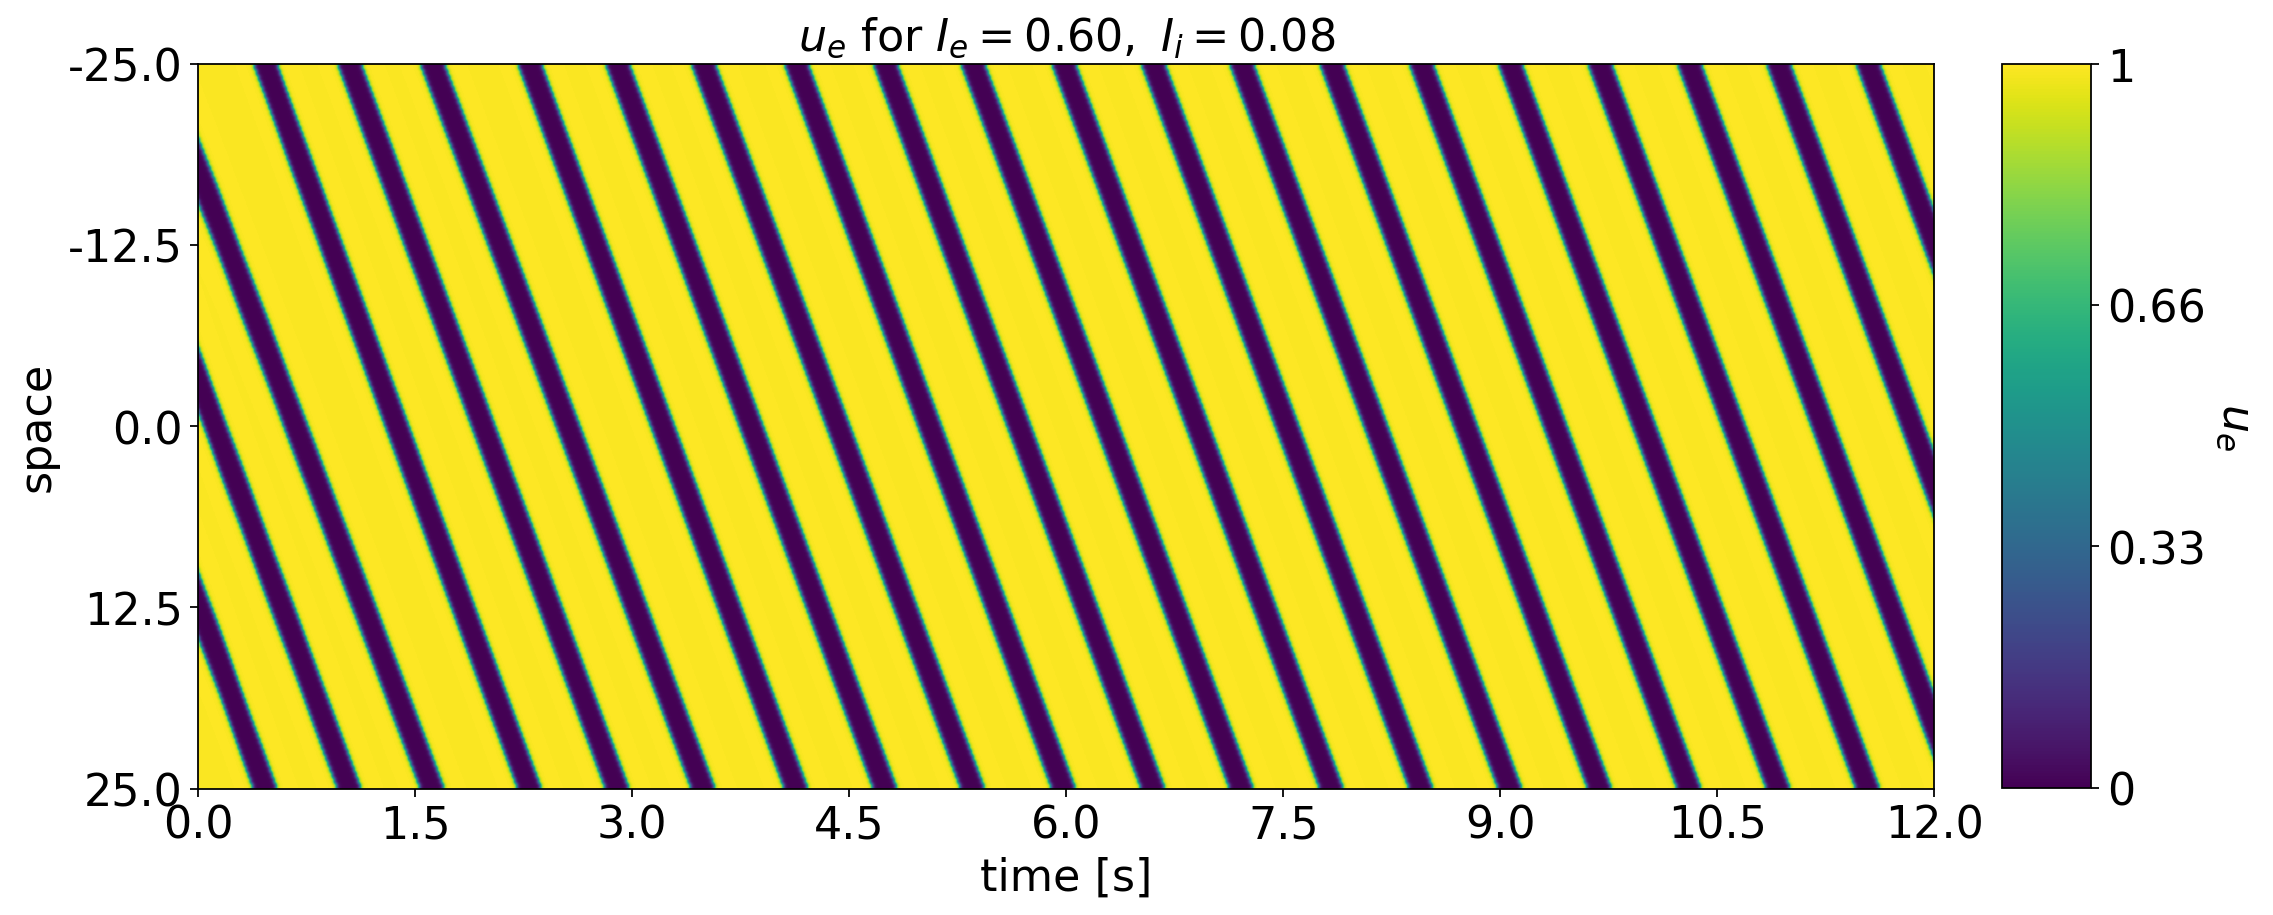

In [42]:
#visualisation of the periodic traveling wave we use for both 
# the average rate as well as the phase latency example

fig, ax = plt.subplots(1, 1, figsize=(14,6), dpi=dpi)

pos = ax.imshow(ue.T[:,-duration:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

#ax.scatter(fast_max, -fast_rotation*fast_count, s=20, color='black')

ax.set_title(label=r'$u_e$' + ' for ' + r'$I_e=%.2f,\ I_i=%.2f$' %(params.I_e, params.I_i), fontsize=fs)

#set x-axis labels
ax.set_xlabel('time [s]', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(len(time_labels)))
ax.set_xticklabels(labels=time_labels, fontsize=fs)

#set y-axis labels
ax.set_ylabel('space', fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(len(space_labels)))
ax.set_yticklabels(labels=space_labels, fontsize=fs)

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom", fontsize=fs)
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1], fontsize=fs)

In [43]:
avg_rate = rateBatchesNd(ue[-duration:,:], batch_size=10)
avg_rate

0.00032267517799995497

## Done for default state space

This feature determination has been done for every spatiotemporal pattern (if initialised in down) of the default state space from above. How one can do so for the state space is shown in the chapter below for $\textit{phase latency}$, here, we only show the result.

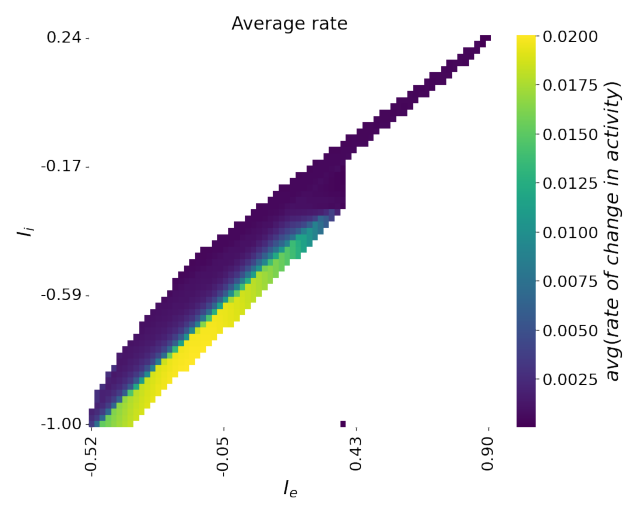

In [45]:
# Load the PNG file
img_path = 'avg-rate.png'
img = plt.imread('imgs/' + img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

# Phase Latency
We used a phase-based method to identify something similar to "velocity/speed" of the periodic traveling waves. We will step-by-step explain the single parts of the pipeline. In the end, the phase latency for every spatiotemporal pattern of the default state space(if initialised around the Turing-unstable fixed point) is determined and then visualised in the state space.


## Step 1: Simulate the activity and compute it's analytical representation 
Determine the analytical representation of the activity time series $u_e(n,t)$ per node $n$ over time $t$ through the application of the Hilbert Transform $H[\cdot]$

$
    u_e(n,t)+iH[u_e(n,t)]=e^{i\phi(n,t)}
$

whereas $\phi(n,t)$ denotes the instantaneous phase of node $n$ at time step $t$, and $i$ the imaginary unit.

In [46]:
#to be able to compute H[ue], we firstly need ue

params={'I_e': 0.6, 'I_i': 0.08, 'end_t': 15*1000, 'b': 0.25,
            'seed': True, 'seed_amp': 0.01}

params = setParams(params)

fps, stab = run_fixedpoints(params)
fp=fps[0]

#if you ran the average-rate already, no need to run again
#ue, ui = run_activity(params, fp=fp)

In [47]:
#set the duration for which you want to compute the hilbert-trafo
#choose one that cuts off the transient time
#e.g. we have a runtim of 15sek, therefore choose a duation of 10sek to compute the hilbert-trafo on the last 10sec
duration = 10
dur_steps = int(duration * (1/params.dt) * 1000) #convert into integration-time-steps

#compute hilbert-trafo and the instantaneous phase per node
signal = hilbert_trafo_nd(ue[-dur_steps:,:], axis=0)
phases = inst_phase(signal)

#cut-off further 2 seconds at the beginning to ensure that there are no variations due to boundaries
phases_cut = phases[-80000:]

In [48]:
#transform into complex space for visualisation reasons
complex_vector = np.exp(1j * phases_cut)
    
# Extract real and imaginary components of the complex vectors
real_part = np.real(complex_vector)
imaginary_part = np.imag(complex_vector)

In [49]:
fs = 20
dpi = 160
time_labels = np.linspace(0,int(len(phases_cut)/10000),9)
space_labels = np.linspace(-int(params.length/2),int(params.length/2),5)
cmap = 'viridis'

## Step 2: Determine the phase latency per node

We start for every node $n$ at time-step t_0 to count the amount of time steps necessary to "pass" the imaginary axis twice (2x zero-crossing) which in turn translates into "how many time steps are necessary for this node to get back to the starting point of one period in the oscillation". 

In [50]:
#cross section of two nodes to visualise what is accounted for
phase_latencies = np.zeros(len(phases_cut.T))

for idx, node in enumerate(phases_cut.T):
        complex_vector = np.exp(1j * node)
        
        # Extract real and imaginary components of the complex vectors
        real_part = np.real(complex_vector)
        imaginary_part = np.imag(complex_vector)
        
        #get the array of all indeces at which the index switches (i.e. indices where imaginary_part crosses the zero-axis)
        how_many_time_steps = getSwitchIndex(imaginary_part)
       # print('for node %i, %s many steps' %(idx, str(how_many_time_steps)))
        
        if len(how_many_time_steps)<=1:
            phase_latencies[idx] = 0
        else:
            #take the second switch to count the #time steps for a full cycle
            phase_latencies[idx] = how_many_time_steps[1]

amount_time_steps = phase_latencies[np.argmax(phase_latencies)]

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3480693064.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/3480693064.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[-1.2, -1.8, -0.4, 0.0, 0.4, 0.8, 1.2], fontsize=fs)


Text(0.8999325879386889, 0.05161118332627116, '$t_K$')

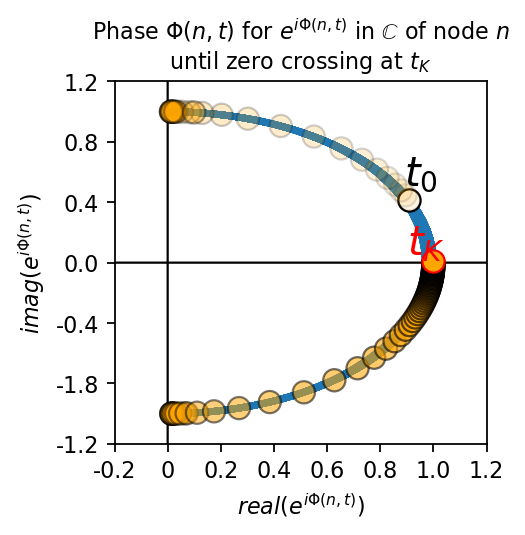

In [51]:
#due to the loop above, we visualise the real-imaginary part of e^phase for the last node
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=dpi)

ax.set_title(label='Phase '+ r'$\Phi(n,t)$' + ' for ' + r'$e^{i\Phi(n,t)}$'+ ' in ' + r'$\mathbb{C}$'+ ' of node ' + r'$n$' + 
             '\n' + 'until zero crossing at ' + r'$t_K$', fontsize=fs)

#only visualise for the last 2 seconds, otherwise it looks too full
rea = real_part#[-20000:]
ima = imaginary_part#[-20000:]

ax.plot(rea, ima, zorder=1)
ax.plot(np.linspace(-0.2,1.2,len(rea)), np.linspace(0,0,len(rea)), c='black', lw=1)
ax.plot(np.linspace(-0,0,len(ima)), np.linspace(-1.2,1.2,len(ima)), c='black', lw=1)

ax.scatter(rea[0], ima[0], 
           facecolors='white', edgecolors='black', zorder=2, s=100)

nmb_nodes = np.linspace(0, phase_latencies[-1], 86).astype(int)

alpha_values = np.linspace(0.1, 1.0, len(nmb_nodes)) 

ax.scatter(rea[nmb_nodes], ima[nmb_nodes], 
           facecolors='orange', edgecolors='black', zorder=2, s=100, alpha=alpha_values)


ax.scatter(rea[int(nmb_nodes[-1]+80)], ima[int(nmb_nodes[-1]+80)], 
           facecolors='orange', edgecolors='red', zorder=2, s=100)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1.2, 1.2])


#set x-axis labels
ax.set_xlabel(r'$real(e^{i\Phi(n,t)})$', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(8))
ax.set_xticklabels(labels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=fs)

#set y-axis labels
ax.set_ylabel(r'$imag(e^{i\Phi(n,t)})$', fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(7))
ax.set_yticklabels(labels=[-1.2, -1.8, -0.4, 0.0, 0.4, 0.8, 1.2], fontsize=fs)

ax.text(rea[0]-0.02, ima[0]+0.1, r'$t_0$')
ax.text(rea[int(nmb_nodes[-1]+80)]-0.1, ima[int(nmb_nodes[-1]+80)]+0.04, r'$t_K$', c='r')

## Step 3: Identify the amount of nodes to finish one oscillation cycle 

To identify "how much space" has to be passed for one oscillation to finish one cycle of an oscillation, we count the amount of nodes from 'closest to zero-crossing' to 'furthest-away from zero-crossing'

In [52]:
#cross section of activity at time step $t_0$ to visualise what is accounted for
rotation = rotation_in_latency(phase_latencies)
amount_of_nodes = count_nodes_for_descent(phase_latencies, rotation)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1435975339.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=space_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1435975339.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=time_labels.astype(int), fontsize=fs)


[Text(0, 2916.4, '0'),
 Text(0, 3810.7000000000003, '1'),
 Text(0, 4705.0, '2'),
 Text(0, 5599.3, '3'),
 Text(0, 6493.6, '4')]

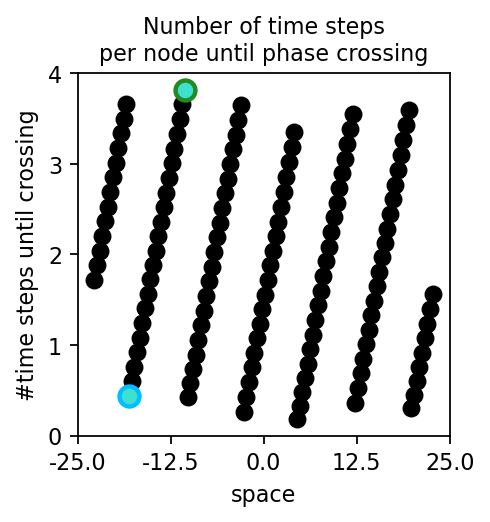

In [53]:
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=dpi)

low = np.argmax(phase_latencies)
high = low + rotation*amount_of_nodes + 1

ax.set_title(label='Number of time steps' + '\n' + 'per node until phase crossing', fontsize=fs)

ax.scatter(np.linspace(-25,25, params.n), phase_latencies, c='black', zorder=0, s=50)
ax.scatter(np.linspace(-25,25, params.n)[low:high], phase_latencies[low:high], c='turquoise', zorder=1, s=60)
ax.scatter(np.linspace(-25,25, params.n)[low], phase_latencies[low], 
           c='turquoise', edgecolor='forestgreen', zorder=2, s=80, lw=2)
ax.scatter(np.linspace(-25,25, params.n)[high-1], phase_latencies[high-1], 
           c='turquoise', edgecolor='deepskyblue', zorder=2, s=80, lw=2)

#set x-axis labels
ax.set_xlabel('space', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xticklabels(labels=space_labels, fontsize=fs)

#set y-axis labels
ax.set_ylabel('#time steps until crossing', fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_yticklabels(labels=time_labels.astype(int), fontsize=fs)

## Step 4: Do so for every parameterization with periodic traveling waves

$\textbf{Hint}$: in the py-folder, the runFuncs.py-file includes a function called 'run_latencies' which does all the single steps from above in one call (without the visualisations).

In [54]:
state_space = pd.read_csv(csv_path + '/adaps_101x101.csv')
state_space = state_space[state_space['p_down']==4]

In [55]:
#Create pandas DataFrame to store the data
df_columns = ['I_e', 'I_i', '#timesteps', '#nodes'] 
df = pd.DataFrame(columns=df_columns)

In [ ]:
#The determination for all traveling waves in the state space are already done and 
# can be found in the csv-file 'phase_latencies.csv'

#Extract two columns into an array of tuples
ee = state_space['I_e']
ii = state_space['I_i']

#Combine values from the two columns
inputs = list(zip(ee, ii))

for tup in inputs:
    params = {'I_e': ee, 'I_i': ii, 'end_t': 15*1000, 
            'b': 0.25, 'tau_a': 600,
            'seed': True, 'seed_amp': 0.01}
    amount_ts, amount_ns = run_latencies(params)
    ls = [[tup[0], tup[1], amount_ts, amount_ns]]
    df_temp = pd.DataFrame(ls, columns=df_columns)
    df = pd.concat([df, df_temp])

#save the entire computation in a csv-file
filestr = 'phase_latencies_jupyterRun.csv'
#writing the new DataFrame to a csv file
#df.to_csv(csv_path + '/' + filestr)

print('Simulation completed.')

## Done for the state space

The phase latencies were already computed for every spatiotemporal pattern (if initalised around down) and is visualised below. The parts above are only to show, how it is done.

*Note:* The necessary duration and space for one cycle of the oscillation to finish is set into relationship by translating the 'amount of time steps' into 'seconds' (assuming that the model simulates in ms and we take an integration time step dt=0.1, i.e., per second we have 1000x10 simulated steps), and the 'amount of nodes' into space, whereas we simply take the amount of nodes x dx (where dx is the discretization of the space, e.g. length=50, #nodesInRing=128, then dx~0.39) Therefore, the combination of both, I interpret as "propagation speed of the traveling wave". It says nothing whatsoever about the temporal or spatial frequency.

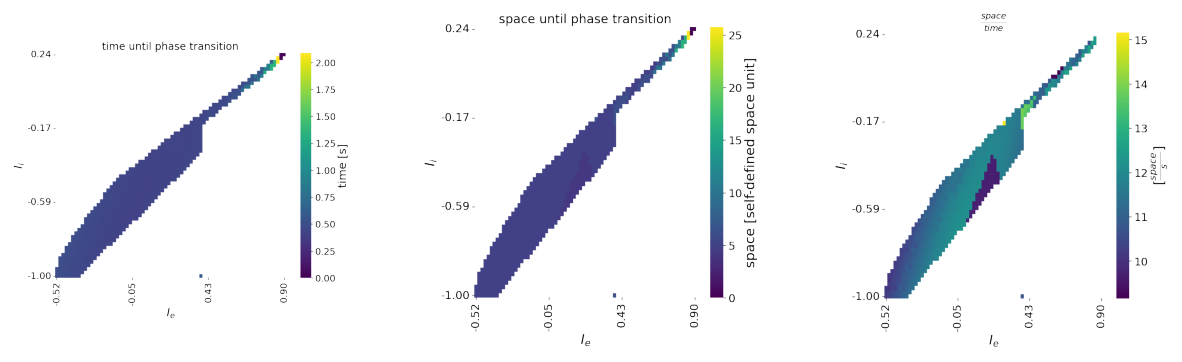

In [57]:
# Load the PNG file
time_path = 'imgs/phase_time.png'
node_path = 'imgs/phase_space.png'
angle_path = 'imgs/phase_speed.png'

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15, 5))

time_img = plt.imread(time_path)
node_img = plt.imread(node_path)
angle_img = plt.imread(angle_path)

# Display the image
ax0.imshow(time_img)
ax1.imshow(node_img)
ax2.imshow(angle_img)

for ax in [ax0, ax1, ax2]:
    ax.axis('off')  # Turn off axis
plt.show()

# Explore for adaptation parameters

As above for the dominant temporal frequencies, we want to explore how the adaptation parameters (here, adaptation strength $b$, and adaptation time constant $\tau_a$). 

## For traveling waves of different properties

Firstly, we start with 7 $(I_e, I_i)$-configurations that show periodic traveling waves for the default setting. Their variations are w.r.t. the instability that occurs and which limit cycle ($LC_{ei}$ or $LC_{ae}$) they belong to.

In [ ]:
inputs = [(-0.4, -0.94),
          (0.0, -0.46),
          (0.04, -0.6), 
          (0.3, -0.2), 
          (0.44, -0.1), 
          (0.6, 0.08), 
          (0.82, 0.16)]

#Create pandas DataFrame to store the data
df_columns = ['b', 'I_e', 'I_i', '#timesteps', '#nodes', 'avg_rate'] 
df = pd.DataFrame(columns=df_columns)

avg_rates = np.zeros(len(inputs))
ts = np.zeros(len(inputs))
ns = np.zeros(len(inputs))
bs = np.linspace(0.1, 0.4, 11)

for b in bs:    
      for idx, tup in enumerate(inputs):
          params = {'I_e': tup[0], 'I_i': tup[1], 'end_t': 15*1000, 
                    'b': b, 'tau_a': 600,
                    'seed': True, 'seed_amp': 0.01}
          
          params = setParams(params)
          fps, stab = run_fixedpoints(params)
          fp=fps[0]
          ue, ui = run_activity(params, fp)
          
          #to descrease computation time, we use a variation of run_latencies that doesn't simulate the activity over again    
          ts_temp, ns_temp = run_latencies_for_activity(params, ue)
          
          #determine the average rate along the way
          duration = int(10 * 1000 * (1/params.dt))
          avg_rate = rateBatchesNd(ue[-duration:,:], batch_size=10)
          
          ts[idx], ns[idx] = ts_temp, ns_temp
          avg_rates[idx] = avg_rate
          
          #save in DataFrame
          ls = [[b, tup[0], tup[1], ts_temp, ns_temp, avg_rate]]
          df_temp = pd.DataFrame(ls, columns=df_columns)
          df = pd.concat([df, df_temp])

#save the entire computation in a csv-file
filestr = 'phase_and_rate_for_increasing_b.csv'
#writing the new DataFrame to a csv file
#f.to_csv(csv_path + '/' + filestr)

print('Simulation completed.')
    

In [58]:
df = pd.read_csv('csv/phase_and_rate_for_increasing_b.csv')
a = df[df['I_e'] == -0.41]
b = df[df['I_e'] == 0.0]
c = df[df['I_e'] == 0.01]
d = df[df['I_e'] == 0.3]
e = df[df['I_e'] == 0.44]
f = df[df['I_e'] == 0.6]
g = df[df['I_e'] == 0.82]

dfList1 = [a, b, c, d, e, f, g]

In [ ]:
inputs = [(-0.4, -0.94),
          (0.0, -0.46),
          (0.04, -0.6), 
          (0.3, -0.2), 
          (0.44, -0.1), 
          (0.6, 0.08), 
          (0.82, 0.16)]

#Create pandas DataFrame to store the data
df_columns = ['tau_a', 'I_e', 'I_i', '#timesteps', '#nodes', 'avg_rate'] 
df = pd.DataFrame(columns=df_columns)

avg_rates = np.zeros(len(inputs))
ts = np.zeros(len(inputs))
ns = np.zeros(len(inputs))
taus = np.linspace(300, 2400, 11)

for tau in taus:    
      for idx, tup in enumerate(inputs):
          params = {'I_e': tup[0], 'I_i': tup[1], 'end_t': 15*1000, 
                    'b': 0.25, 'tau_a': tau,
                    'seed': True, 'seed_amp': 0.01}
          params = setParams(params)
          fps, stab = run_fixedpoints(params)
          fp=fps[0]
          ue, ui = run_activity(params, fp)
          
          #to descrease computation time, we use a variation of run_latencies that doesn't simulate the activity over again    
          ts_temp, ns_temp = run_latencies_for_activity(params, ue)
          
          #determine the average rate along the way
          duration = int(10 * 1000 * (1/params.dt))
          avg_rate = rateBatchesNd(ue[-duration:,:], batch_size=10)
          
          ts[idx], ns[idx] = ts_temp, ns_temp
          avg_rates[idx] = avg_rate
          
          #save in DataFrame
          ls = [[tau, tup[0], tup[1], ts_temp, ns_temp, avg_rate]]
          df_temp = pd.DataFrame(ls, columns=df_columns)
          df = pd.concat([df, df_temp])

#save the entire computation in a csv-file
filestr = 'phase_and_rate_for_increasing_tau.csv'
#writing the new DataFrame to a csv file
# df.to_csv(csv_path + '/' + filestr)

print('Simulation completed.')
    

In [59]:
df = pd.read_csv('csv/phase_and_rate_for_increasing_tau.csv')
a = df[df['I_e'] == -0.41]
b = df[df['I_e'] == 0.0]
c = df[df['I_e'] == 0.01]
d = df[df['I_e'] == 0.3]
e = df[df['I_e'] == 0.44]
f = df[df['I_e'] == 0.6]
g = df[df['I_e'] == 0.82]

dfList2 = [a, b, c, d, e, f, g]

In [60]:
inputs = [(-0.4, -0.94),
          (0.0, -0.46),
          (0.04, -0.6), 
          (0.3, -0.2), 
          (0.44, -0.1), 
          (0.6, 0.08), 
          (0.82, 0.16)]

labels = [r'$I_e=%.2f, I_i=%.2f$' %(tup[0], tup[1]) for tup in inputs]
features = ['#timesteps', '#nodes', 'avg_rate']
colors = cm.get_cmap('Accent', len(labels))
titles = ['#timesteps', '#nodes', 'avg. rate']

In [61]:
colors = ['lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite', 'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue', 
          'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 
          'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum', 'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 
          'orchid', 'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush', 'palevioletred', 'crimson', 'pink', 'lightpink']

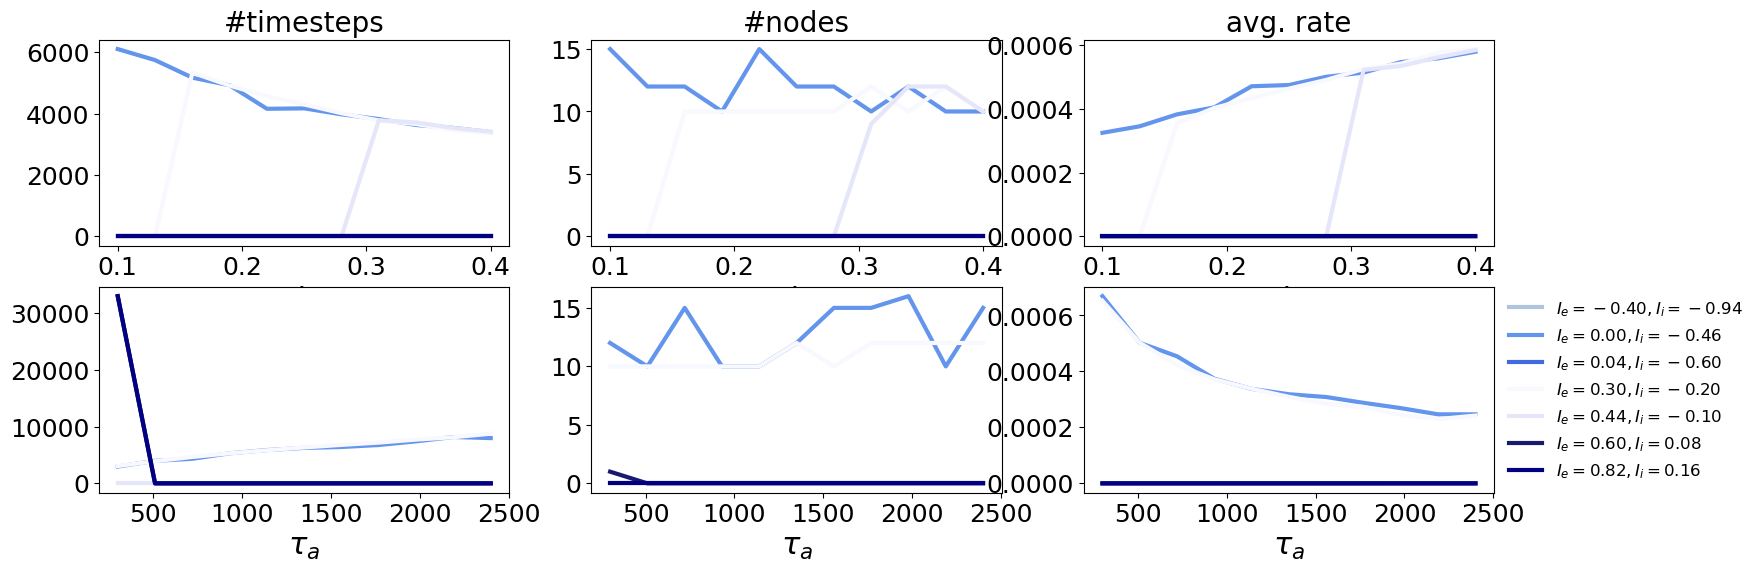

In [62]:
plotDataFrames(dfList1, dfList2, features=features, labels=labels, colors=colors, titles=titles)

In [63]:
def plotSpaces(dfList1, dfList2, 
                z='p_random', x='I_e', y='I_i', 
                vmin=None, vmax=None, 
                cbar_labels=None,
                cbar_title = 'avg. rate',
                contours=False,
                solid='stability',
                dashed = 'static',
                labels=['(i)', '(ii)', '(iii)', '(iv)'], 
                cmap = 'viridis',
                titles=['dom. temp. frequ. [Hz]', 
                        'down duration ' + r'$[\frac{ratio}{oscillation}]$', 
                        'up duration ' + r'$[\frac{ratio}{oscillation}]$']):
    
    nmb_cols = len(dfList1)

    fig, axes = plt.subplots(2, nmb_cols, figsize=(nmb_cols*4, 8), sharey=True, sharex=True)

    pivot_ax = dfList2[-1].pivot(index=y, columns=x, values=z)[::-1]
    mini = np.nanmin(pivot_ax.values)
    maxi = np.nanmax(pivot_ax.values)

    if not vmin and not vmax:
        vmin=mini
        vmax=maxi
    else: 
        vmin=vmin
        vmax=vmax

    for idx, ax in enumerate(axes[0]): 
        # Plot the DataFrame as a heatmap
        h = sns.heatmap(dfList1[idx].pivot(index=y, columns=x, values=z)[::-1], 
                    annot=False, cmap=cmap, linewidths=0.5, ax=ax,
                    fmt='.2f', vmin=vmin, vmax=vmax,)
        if contours:
            ax.contour(dfList1[idx].pivot(index=y, columns=x, values=solid)[::-1], colors='black', levels=dfList1[idx][solid].values)
            ax.contour(dfList1[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList1[idx][dashed].values)
        ax.set_title(titles[1, idx]) 
        ax.set_title(titles[0, idx])
        ax.set_xlabel('')
        ax.set_ylabel('')
        cbar = h.collections[0].colorbar
        cbar.remove()



    for idx, ax in enumerate(axes[1]): 
        # Plot the DataFrame as a heatmap
        h = sns.heatmap(dfList2[idx].pivot(index=y, columns=x, values=z)[::-1], 
                    annot=False, cmap=cmap, linewidths=0.5, ax=ax,
                    fmt='.2f', cbar=False, vmin=vmin, vmax=vmax)
        if contours:
            ax.contour(dfList2[idx].pivot(index=y, columns=x, values=solid)[::-1], colors='black', levels=dfList2[idx][solid].values)
            ax.contour(dfList2[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList2[idx][dashed].values)
        ax.set_title(titles[1, idx]) 
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Show only 4  per axis
    for ax in axes[:,0]:
        ax.set_yticks(np.linspace(0.5, len(pivot_ax.index) - 0.5, 4), 
                [f'{y:.2f}' for y in np.linspace(pivot_ax.index.max(), pivot_ax.index.min(), 4)])
        ax.set_ylabel(r'$I_i$')

    for ax in axes[1,:]:
        ax.set_xticks(np.linspace(0.5, len(pivot_ax.columns) - 0.5, 4),
                             [f'{x:.2f}' for x in np.linspace(pivot_ax.columns.min(), pivot_ax.columns.max(), 4)])
        ax.set_xlabel(r'$I_e$')
    

    cbar_ticks=np.linspace(mini,maxi,4)
    #cbar_ticks=np.around(cbar_ticks, decimals=5)

    mini = mini - (10e-5*mini)
    maxi = maxi + (10e-5*maxi) 
    
    if cbar_labels:
        cbar_ticks=np.linspace(mini+0.5, maxi-0.1,4)
        cbar_labels=cbar_labels
    else: 
        cbar_labels = np.linspace(mini,maxi,4)
        cbar_labels = np.around(cbar_labels, decimals=5)
    
    # Create colorbar
    cb_ax = fig.add_axes([.95,.125,.02,.75])
    cbar = plt.colorbar(axes[1,-1].collections[0], ticks=cbar_ticks,
                        cax=cb_ax)
    cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")
    cbar.ax.set_yticklabels(cbar_labels, rotation=-90)
    cbar.minorticks_off()

    plt.show()

    

In [64]:
a = pd.read_csv('csv/adaps-b-01.csv')
b = pd.read_csv('csv/adaps-b-02.csv')
c = pd.read_csv('csv/adaps-b-03.csv')
d = pd.read_csv('csv/adaps-b-04.csv')

e = pd.read_csv('csv/adaps-taua-300.csv')
f = pd.read_csv('csv/adaps-taua-900.csv')
g = pd.read_csv('csv/adaps-taua-1200.csv')
h = pd.read_csv('csv/adaps-taua-1600.csv')

dfList1 = [a, b, c, d] 
dfList2 = [e, f, g, h]

titles = np.array([[r'$b=0.1,\ \tau_a=600$',
          r'$b=0.2,\ \tau_a=600$',
          r'$b=0.3,\ \tau_a=600$',
          r'$b=0.4,\ \tau_a=600$'],
          [r'$b=0.25,\ \tau_a=300$',
          r'$b=0.25,\ \tau_a=900$',
          r'$b=0.25,\ \tau_a=1200$',
          r'$b=0.25,\ \tau_a=1600$']])

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:37: UserWarning: No contour levels were found within the data range.
  ax.contour(dfList1[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList1[idx][dashed].values)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:37: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(dfList1[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList1[idx][dashed].values)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:54: UserWarning: No contour levels were found within the data range.
  ax.contour(dfList2[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList2[idx][dashed].values)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:54: UserWarning: The following kwarg

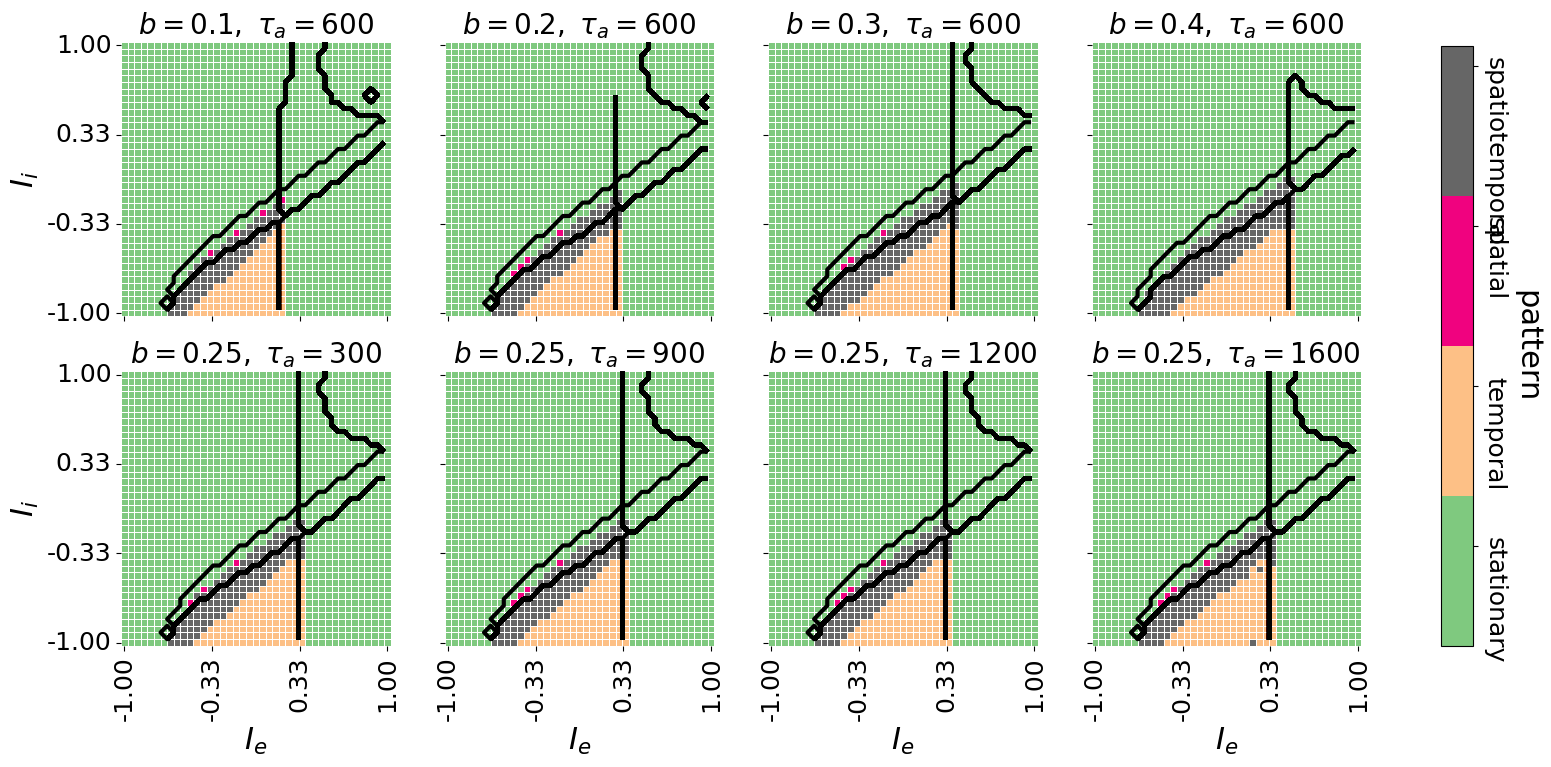

In [65]:
plotSpaces(dfList1, dfList2, z='p_random', contours=True,  
           cbar_labels=['stationary', 'temporal', 'spatial', 'spatiotemporal'], cbar_title='pattern', 
           titles=titles, cmap=cm.get_cmap('Accent', 4))

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:37: UserWarning: No contour levels were found within the data range.
  ax.contour(dfList1[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList1[idx][dashed].values)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:37: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(dfList1[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList1[idx][dashed].values)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:54: UserWarning: No contour levels were found within the data range.
  ax.contour(dfList2[idx].pivot(index=y, columns=x, values=dashed)[::-1], colors='black', linestyle='dashed', levels=dfList2[idx][dashed].values)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3724/1390085541.py:54: UserWarning: The following kwarg

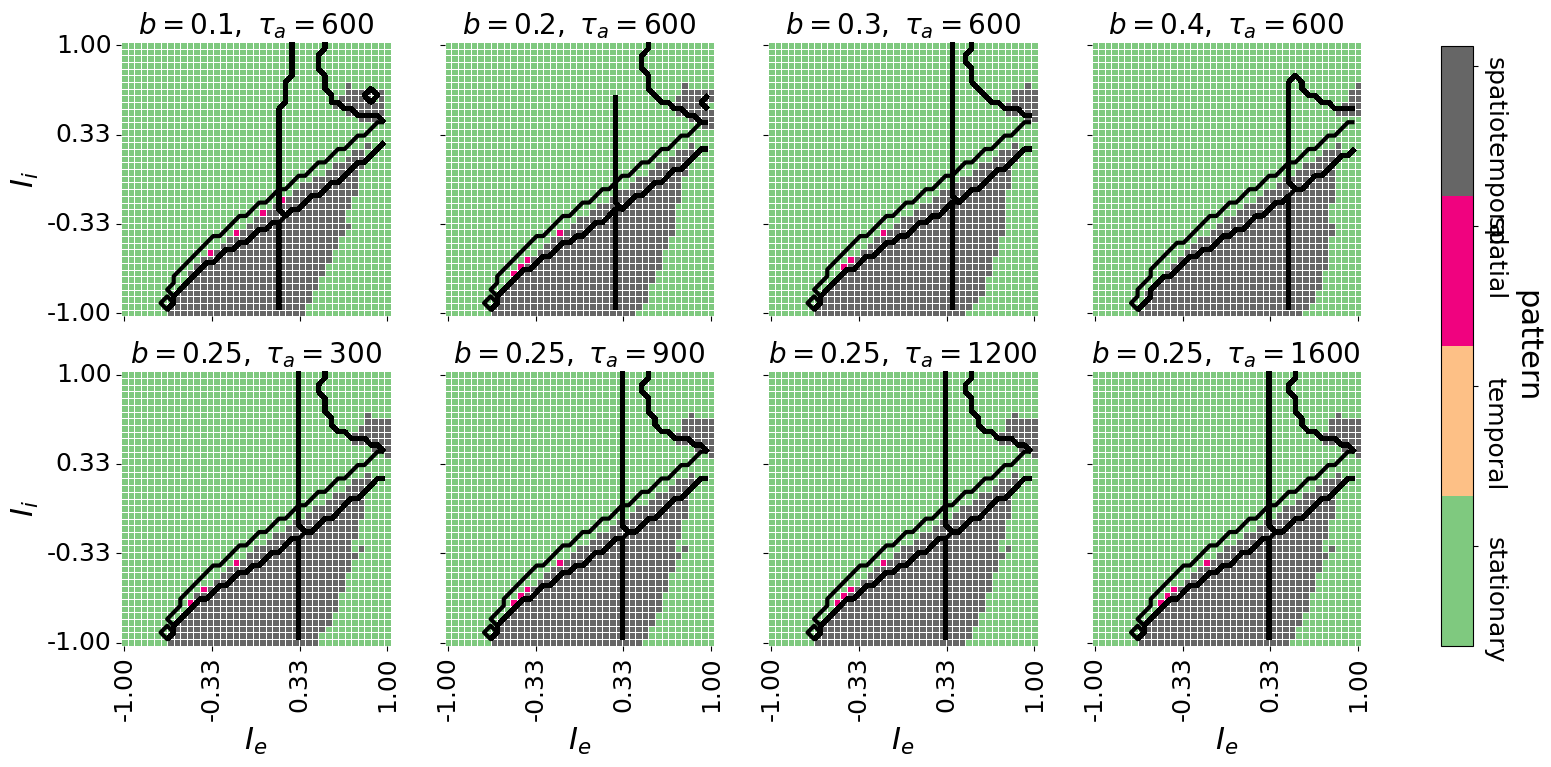

In [66]:
plotSpaces(dfList1, dfList2, z='p_down', contours=True,  
           cbar_labels=['stationary', 'temporal', 'spatial', 'spatiotemporal'], cbar_title='pattern', 
           titles=titles, cmap=cm.get_cmap('Accent', 4))

In [67]:
a = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-b-01.csv')
b = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-b-02.csv')
c = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-b-03.csv')
d = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-b-04.csv')

e = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-taua-300.csv')
f = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-taua-900.csv')
g = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-taua-1200.csv')
h = pd.read_csv('csv/adaps-b-tau/avg-rateadaps-taua-1600.csv')

dfList1_rate = [a, b, c, d] 
dfList2_rate = [e, f, g, h]

titles = np.array([[r'$b=0.1,\ \tau_a=600$',
          r'$b=0.2,\ \tau_a=600$',
          r'$b=0.3,\ \tau_a=600$',
          r'$b=0.4,\ \tau_a=600$'],
          [r'$b=0.25,\ \tau_a=300$',
          r'$b=0.25,\ \tau_a=900$',
          r'$b=0.25,\ \tau_a=1200$',
          r'$b=0.25,\ \tau_a=1600$']])

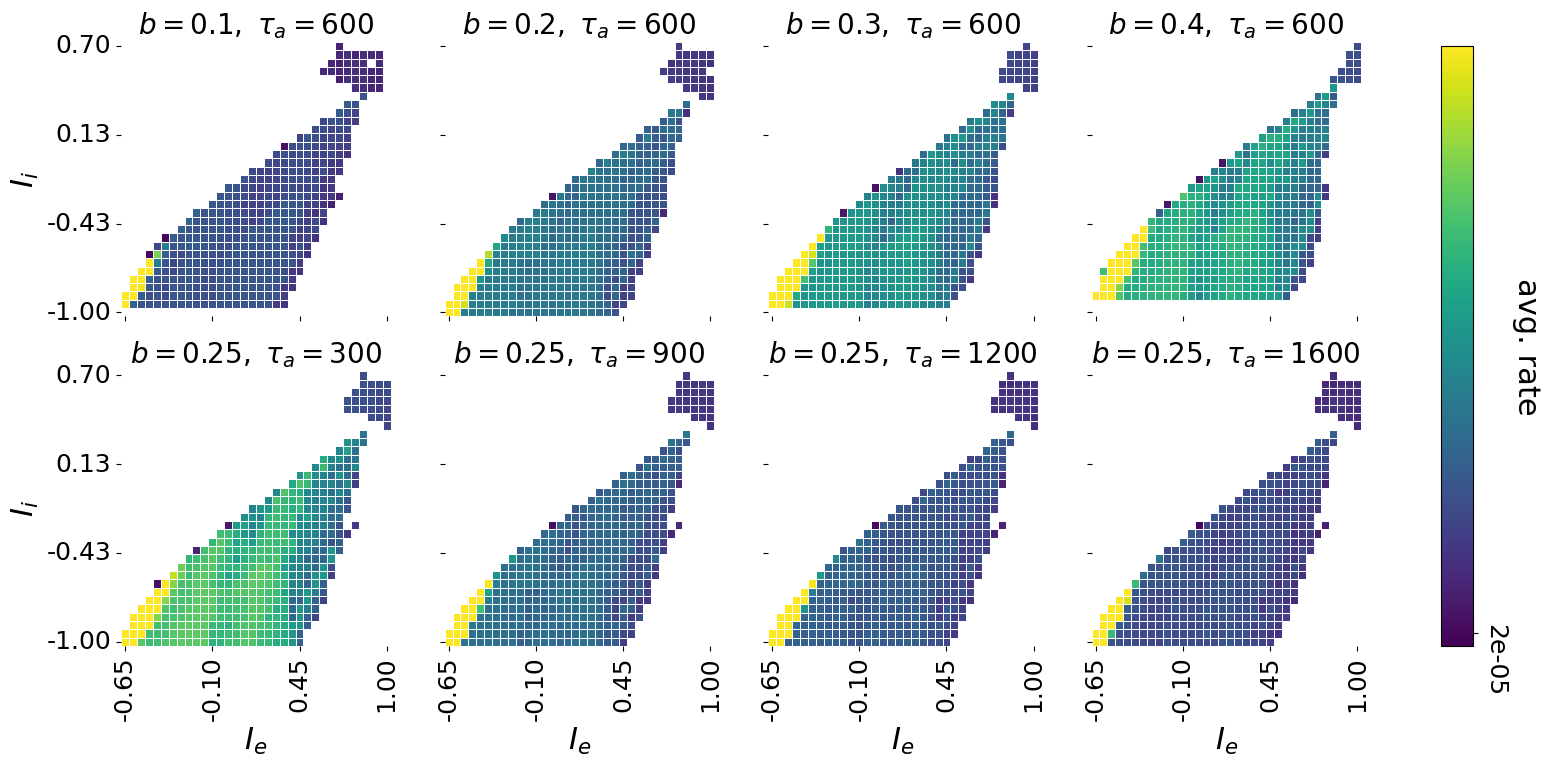

In [68]:
pivot_ax = dfList2_rate[-1].pivot(index='I_i', columns='I_e', values='avg_rate')[::-1]
plotSpaces(dfList1_rate, dfList2_rate, z='avg_rate', titles=titles,
           vmin=0, vmax=np.nanmax(pivot_ax)/5)

In [69]:
a = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-b-01.csv')
b = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-b-02.csv')
c = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-b-03.csv')
d = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-b-04.csv')

e = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-taua-300.csv')
f = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-taua-900.csv')
g = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-taua-1200.csv')
h = pd.read_csv('csv/adaps-b-tau/phase-latencies-adaps-taua-1600.csv')

dfList1_phase = [a, b, c, d] 
dfList2_phase = [e, f, g, h]

titles = np.array([[r'$b=0.1,\ \tau_a=600$',
          r'$b=0.2,\ \tau_a=600$',
          r'$b=0.3,\ \tau_a=600$',
          r'$b=0.4,\ \tau_a=600$'],
          [r'$b=0.25,\ \tau_a=300$',
          r'$b=0.25,\ \tau_a=900$',
          r'$b=0.25,\ \tau_a=1200$',
          r'$b=0.25,\ \tau_a=1600$']])

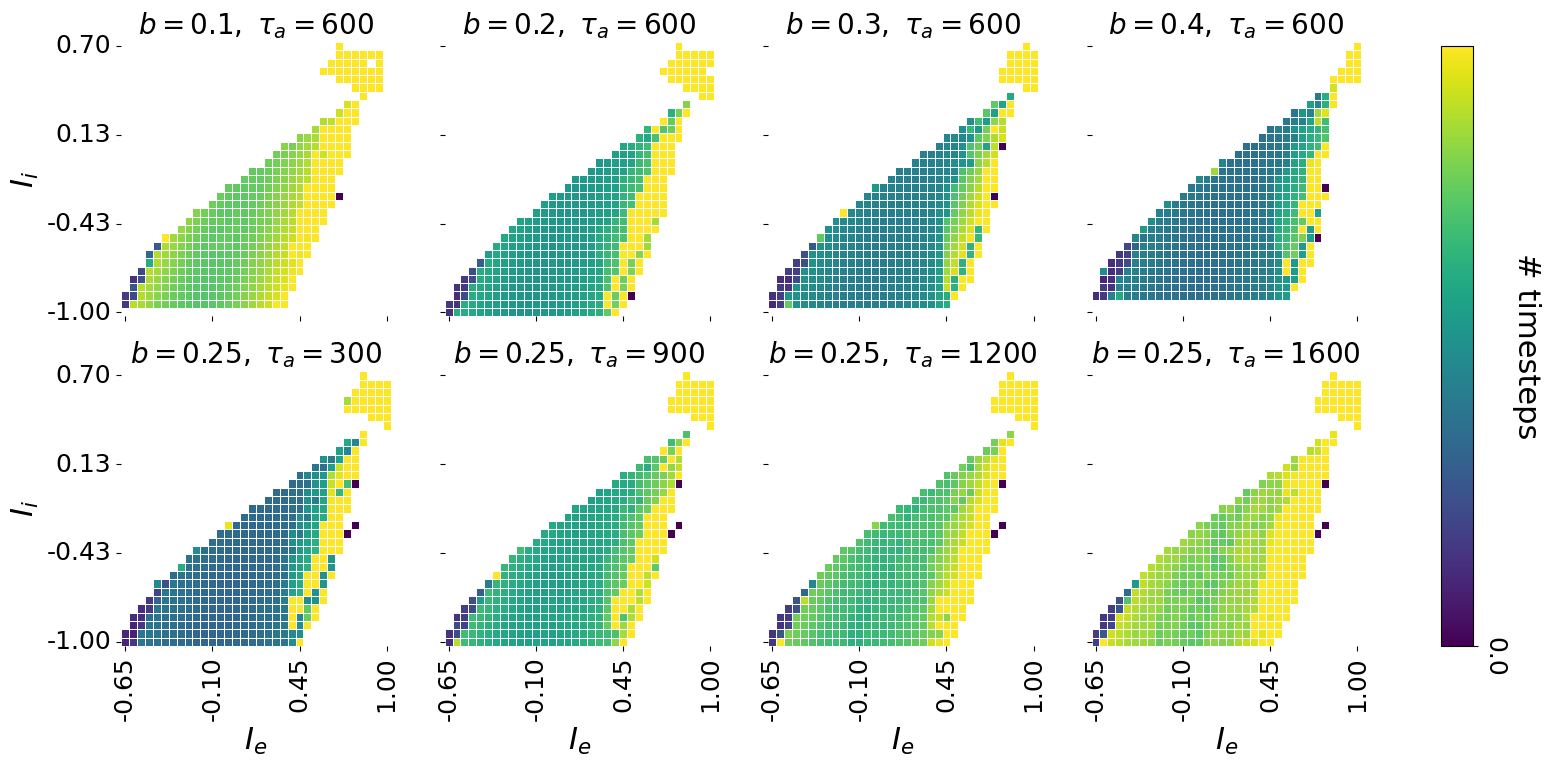

In [70]:
pivot_ax = dfList2_phase[-1].pivot(index='I_i', columns='I_e', values='#timesteps')[::-1]
plotSpaces(dfList1_phase, dfList2_phase, z='#timesteps', cbar_title='# timesteps', titles=titles,
           vmin=0, vmax=np.nanmax(pivot_ax)/4)

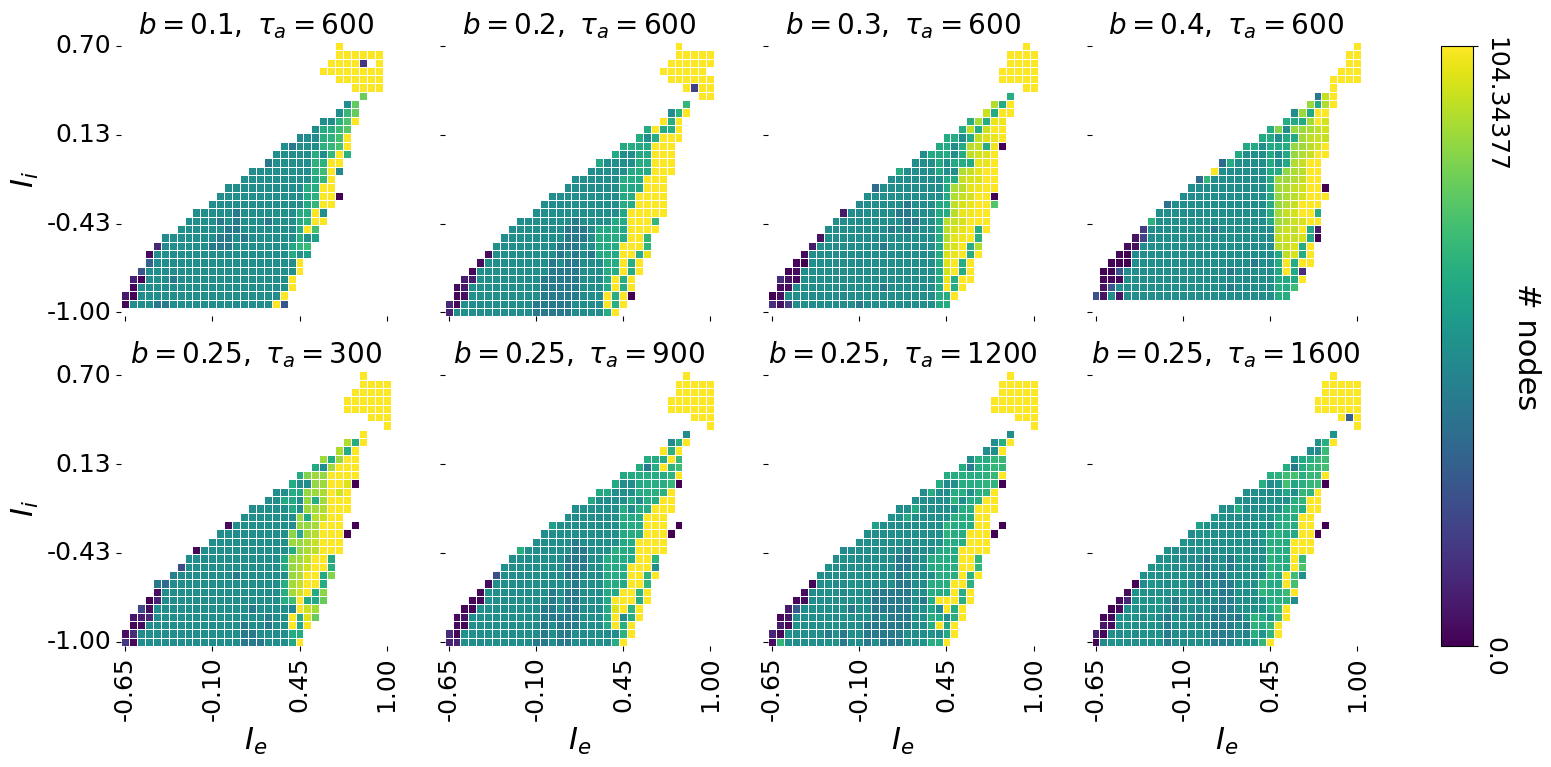

In [71]:
pivot_ax = dfList2_phase[-1].pivot(index='I_i', columns='I_e', values='#nodes')[::-1]
plotSpaces(dfList1_phase, dfList2_phase, z='#nodes', cbar_title='# nodes', titles=titles,
           vmin=0, vmax=np.nanmax(pivot_ax)/3)

In [72]:
rate_averages_b = np.zeros(4)
rate_averages_taua = np.zeros(4)
rate_variances_b = np.zeros(4)
rate_variances_taua = np.zeros(4)

timestep_averages_b = np.zeros(4)
timestep_averages_taua = np.zeros(4)
timestep_variances_b = np.zeros(4)
timestep_variances_taua = np.zeros(4)

nodes_averages_b = np.zeros(4)
nodes_averages_taua = np.zeros(4)
nodes_variances_b = np.zeros(4)
nodes_variances_taua = np.zeros(4)

for i in range(4):
    rate_averages_b[i] = dfList1_rate[i]['avg_rate'].mean()
    rate_variances_b[i] = dfList1_rate[i]['avg_rate'].var()
    rate_averages_taua[i] = dfList2_rate[i]['avg_rate'].mean()
    rate_variances_taua[i] = dfList2_rate[i]['avg_rate'].var()

    timestep_averages_b[i] = dfList1_phase[i]['#timesteps'].mean()
    timestep_variances_b[i] = dfList1_phase[i]['#timesteps'].var()
    timestep_averages_taua[i] = dfList2_phase[i]['#timesteps'].mean()
    timestep_variances_taua[i] = dfList2_phase[i]['#timesteps'].var()

    nodes_averages_b[i] = dfList1_phase[i]['#nodes'].mean()
    nodes_variances_b[i] = dfList1_phase[i]['#nodes'].var()
    nodes_averages_taua[i] = dfList2_phase[i]['#nodes'].mean()
    nodes_variances_taua[i] = dfList2_phase[i]['#nodes'].var()




In [73]:
averages_b = [rate_averages_b, timestep_averages_b, nodes_averages_b]
averages_taua = [rate_averages_taua, timestep_averages_taua, nodes_averages_taua]

variances_b = [rate_variances_b, timestep_variances_b, nodes_variances_b]
variances_taua = [rate_variances_taua, timestep_variances_taua, nodes_variances_taua]

#set the variance in relation to the average and make it smaller 
#to show trajectory of mean over b&taua
for i in range(3):
    variances_b[i] = (variances_b[i]/averages_b[i])*0.2
    variances_taua[i] = (variances_taua[i]/averages_taua[i])*0.2

titles = ['avg. rate', 'avg. #timesteps', 'avg. #nodes']

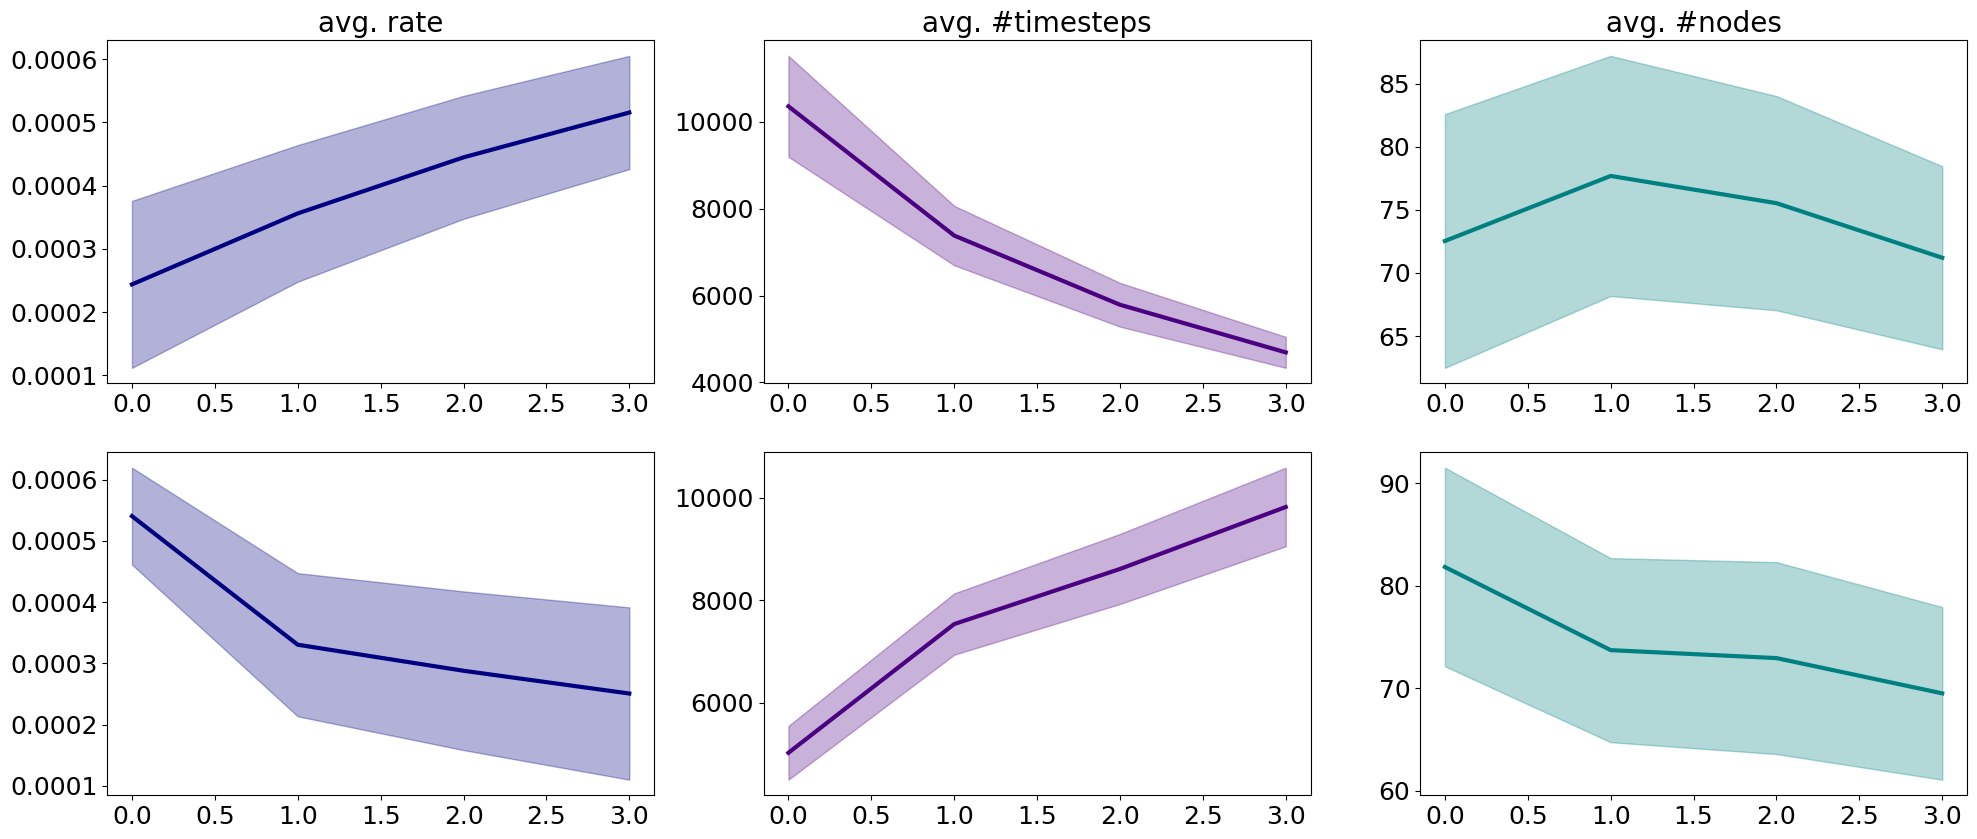

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(24,10))

# Define x-axis values (e.g., indices)
x = range(len(rate_averages_b))
colors = ['navy', 'indigo', 'teal']

for idx, ax in enumerate(axes[0]):
    ax.plot(averages_b[idx], color=colors[idx])
    ax.fill_between(x, averages_b[idx] - variances_b[idx], 
                     averages_b[idx] + variances_b[idx], color=colors[idx], 
                     alpha=0.3, label='Variance')
    ax.set_title(titles[idx])

for idx, ax in enumerate(axes[1]):
    ax.plot(averages_taua[idx], color=colors[idx])
    ax.fill_between(x, averages_taua[idx] - variances_taua[idx], 
                     averages_taua[idx] + variances_taua[idx], color=colors[idx], 
                     alpha=0.3, label='Variance')


plt.show()


In [ ]:
def add_ratio(df_array):
    
    for df in df_array:
        df_down_ratio = df['down_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
        df_up_ratio = df['up_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
        
        # Using DataFrame.insert() to add a column
        df.insert(4, "down_duration_ratio", df_down_ratio, True)
        df.insert(6, "up_duration_ratio", df_up_ratio, True)